In [ ]:

import os
os.makedirs('/content/Processed', exist_ok=True)

from google.colab import drive
drive.mount('/content/drive')

Cloning into 'Low-Medical-Imaging'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 141 (delta 67), reused 111 (delta 37), pack-reused 0 (from 0)
Receiving objects: 100% (141/141), 4.60 MiB | 10.78 MiB/s, done.
Resolving deltas: 100% (67/67), done.
/content/Low-Medical-Imaging
Mounted at /content/drive


In [2]:
!pip install torchinfo

In [3]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'\ndevice: {device}')


device: cuda


In [4]:
import os
import torch
import cv2
import numpy as np
from pathlib import Path
from typing import Tuple, List, Dict, Optional
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import time
from sklearn.model_selection import StratifiedKFold
from torch.cuda.amp import GradScaler, autocast
import csv
from tqdm.auto import tqdm

class ChestXrayDataset(Dataset):

    def __init__(self,
                 dataset_root: str,
                 split: str = "train",
                 image_size: Tuple[int, int] = (448,448),
                 augment: bool = True,
                 normalize: bool = True,
                 augmentation_strength: float = 0.5):
        self.dataset_root = dataset_root
        self.split = split
        self.image_size = image_size
        self.augment = augment
        self.normalize = normalize
        self.augmentation_strength = augmentation_strength

        self.label_map = {"NORMAL": 0, "PNEUMONIA": 1}
        self.images = []
        self.labels = []

        self._load_image_paths()
        self.augmentation_transforms = self._get_augmentation_transforms()
        self.normalization_transforms = self._get_normalization_transforms()

    def _load_image_paths(self):
        """Load all image paths from the dataset directory."""
        split_dir = os.path.join(self.dataset_root, self.split)

        if not os.path.exists(split_dir):
            raise ValueError(f"Split directory {split_dir} does not exist.")

        for label, label_idx in self.label_map.items():
            label_dir = os.path.join(split_dir, label)

            if not os.path.exists(label_dir):
                print(f"Warning: Label directory {label_dir} does not exist. Skipping.")
                continue

            for img_name in os.listdir(label_dir):
                if img_name.lower().endswith(('.jpeg', '.jpg', '.png')):
                    img_path = os.path.join(label_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(label_idx)

        if len(self.images) == 0:
            raise ValueError(f"No images found in {split_dir}")

        print(f"Loaded {len(self.images)} images from {self.split} split.")

    def _get_augmentation_transforms(self) -> transforms.Compose:
        aug_list = [
            transforms.RandomRotation(degrees=20 * self.augmentation_strength),
            transforms.RandomAffine(degrees=0, translate=(0.1 * self.augmentation_strength, 0.1 * self.augmentation_strength)),
            transforms.RandomHorizontalFlip(p=0.5 * self.augmentation_strength),
        ]

        return transforms.Compose(aug_list)

    def _get_normalization_transforms(self) -> transforms.Compose:
        return transforms.Compose([
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img_path = self.images[idx]
        label = self.labels[idx]

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Failed to load image: {img_path}")
        img = cv2.resize(img, (self.image_size[1], self.image_size[0]))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_pil = Image.fromarray(img_rgb)
        img_tensor = transforms.ToTensor()(img_pil)

        if self.augment and self.split == "train":
            img_tensor = self.augmentation_transforms(img_tensor)
        img_tensor = torch.clamp(img_tensor, 0, 1)
        # Apply normalization
        if self.normalize:
            img_tensor = self.normalization_transforms(img_tensor)

        return img_tensor, label

In [5]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import cv2
from PIL import Image
from typing import List

class CustomImageDataset(Dataset):

    def __init__(self,
                 images: List[str],
                 labels: List[int],
                 augment: bool = False,
                 normalize: bool = True,
                 image_size: tuple = (448, 448),
                 augmentation_strength: float = 0.5):

        self.images = images
        self.labels = labels
        self.augment = augment
        self.normalize = normalize
        self.image_size = image_size
        self.augmentation_strength = augmentation_strength
        self.augmentation_transforms = self._get_augmentation_transforms()
        self.normalization_transforms = self._get_normalization_transforms()

    def _get_augmentation_transforms(self):
        aug_list = [
            transforms.RandomRotation(degrees=20 * self.augmentation_strength),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.1 * self.augmentation_strength, 0.1 * self.augmentation_strength)
            ),
            transforms.RandomHorizontalFlip(p=0.5 * self.augmentation_strength),
        ]
        return transforms.Compose(aug_list)

    def _get_normalization_transforms(self):
        return transforms.Compose([
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Failed to load image: {img_path}")
        img = cv2.resize(img, (self.image_size[1], self.image_size[0]))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_pil = Image.fromarray(img_rgb)
        img_tensor = transforms.ToTensor()(img_pil)
        if self.augment:
            img_tensor = self.augmentation_transforms(img_tensor)
        img_tensor = torch.clamp(img_tensor, 0, 1)
        if self.normalize:
            img_tensor = self.normalization_transforms(img_tensor)

        return img_tensor, label

In [6]:
Data_Root = Path('/content/drive/MyDrive/chest_xray')
data_full_train = ChestXrayDataset(Data_Root,split="train",
    augment=False,
    normalize=False )
SUBSET_JSON = "/content/Processed/subset_indices_300.json"
SUBSET_SIZE = 300
SEED = 42

Loaded 5216 images from train split.


In [7]:
print(data_full_train)
img, label = data_full_train[0]
print(f"Image shape: {img.shape}")
print(f"Label: {label}")
print(f"Image dtype: {img.dtype}")

Image shape: torch.Size([3, 448, 448])
Label: 0
Image dtype: torch.float32


In [8]:
'''Creating subset of 300 images for Pheumonia detection task'''
import json
from pathlib import Path
from typing import Optional, List, Dict
import numpy as np
from collections import defaultdict
from torch.utils.data import Subset

def _rng(seed: int):
    """Return a numpy Generator for reproducible sampling."""
    return np.random.default_rng(seed)

def create_subset_indices(
    dataset,
    subset_size: Optional[int] = None,
    per_class: Optional[int] = None,
    seed: int = 42,
    save_path: str = "data/processed/subset_indices.json",
    patient_col: Optional[str] = None
) -> Dict:
    rng = _rng(seed)

    # Validate dataset exposes labels
    if not hasattr(dataset, "labels"):
        raise ValueError("Dataset must expose `labels` (list or array) in the same order as indexing.")

    labels_arr = np.array(dataset.labels)
    unique_classes = np.unique(labels_arr).tolist()
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)

    '''This block samples patients instead of images to avoid data leakage. It requires a patient identifier column
    in the dataset's dataframe (dataset.df) to group images'''
    if patient_col and hasattr(dataset, "df") and patient_col in dataset.df.columns:
        # build patient -> list(indices) mapping and patient -> class mapping (dominant label)
        patient_to_indices = defaultdict(list)
        for idx, pid in enumerate(dataset.df[patient_col].values):
            patient_to_indices[pid].append(idx)

        # map patient -> class (majority class of that patient's images)
        patient_to_class = {}
        for pid, inds in patient_to_indices.items():
            labs = labels_arr[inds]
            # majority label for patient
            vals, counts = np.unique(labs, return_counts=True)
            patient_to_class[pid] = int(vals[np.argmax(counts)])

        # Prepare per-class list of patients
        class_to_patients = defaultdict(list)
        for pid, cls in patient_to_class.items():
            class_to_patients[int(cls)].append(pid)

        indices_selected = []

        if per_class is not None:
            # select patients per class until we have enough images or hit patient count
            for cls in unique_classes:
                pats = class_to_patients[int(cls)]
                rng.shuffle(pats)
                sel_pats = []
                img_count = 0
                for p in pats:
                    sel_pats.append(p)
                    img_count += len(patient_to_indices[p])
                    if img_count >= per_class:
                        break
                # expand to indices
                for p in sel_pats:
                    indices_selected.extend(patient_to_indices[p])
        else:
            # sample patients (balanced across classes proportionally) until >= subset_size images
            # flatten a patient list with class labels to sample from
            all_patients = list(patient_to_indices.keys())
            rng.shuffle(all_patients)
            selected_patients = []
            total_images = 0
            # simple greedy collect until reaching subset_size
            for p in all_patients:
                selected_patients.append(p)
                total_images += len(patient_to_indices[p])
                if subset_size is not None and total_images >= subset_size:
                    break
            for p in selected_patients:
                indices_selected.extend(patient_to_indices[p])

        indices = np.array(sorted(set(indices_selected)), dtype=int)

    else:

        class_indices = {int(c): np.where(labels_arr == c)[0] for c in unique_classes}

        if per_class is not None:
            # sample exactly per_class from each class (if available)
            indices = []
            for cls, inds in class_indices.items():
                if len(inds) < per_class:
                    raise ValueError(f"Not enough samples in class {cls}: requested {per_class}, available {len(inds)}")
                sel = rng.choice(inds, size=per_class, replace=False)
                indices.append(sel)
            indices = np.concatenate(indices)
        else:
            # stratified sampling proportional to class frequencies
            if subset_size is None:
                raise ValueError("Either subset_size or per_class must be provided.")
            # compute class quotas (rounding: last class gets remainder)
            counts = {cls: len(inds) for cls, inds in class_indices.items()}
            total_available = sum(counts.values())
            proportions = {cls: counts[cls] / total_available for cls in counts}
            indices = []
            remaining = subset_size
            classes = list(class_indices.keys())
            for i, cls in enumerate(classes):
                if i == len(classes) - 1:
                    k = remaining
                else:
                    k = int(round(proportions[cls] * subset_size))
                    remaining -= k
                k = min(k, len(class_indices[cls]))
                sel = rng.choice(class_indices[cls], size=k, replace=False)
                indices.append(sel)
            indices = np.concatenate(indices)
    # final shuffle of indices
    indices = np.array(indices, dtype=int)
    rng.shuffle(indices)

    info = {
        "indices": indices.tolist(),
        "subset_size": len(indices),
        "seed": int(seed),
        "per_class": int(per_class) if per_class is not None else None,
        "patient_level": bool(patient_col is not None and hasattr(dataset, "df") and patient_col in dataset.df.columns),
    }
    # compute class counts
    unique, counts = np.unique(labels_arr[indices], return_counts=True)
    info["class_counts"] = {int(u): int(c) for u, c in zip(unique.tolist(), counts.tolist())}

    with open(save_path, "w") as f:
        json.dump(info, f, indent=2)

    print(f"[subset_utils] Saved subset indices ({info['subset_size']}) to {save_path}")
    return info


def load_subset(dataset, indices_path: str = "data/processed/subset_indices.json"):
    path = Path(indices_path)
    if not path.exists():
        raise FileNotFoundError(f"Subset indices JSON not found: {path}")
    with open(path, "r") as f:
        info = json.load(f)
    indices = info["indices"]
    print(f"[subset_utils] Loaded {len(indices)} indices from {indices_path}")
    return Subset(dataset, indices) # return a Subset object

In [9]:
info = create_subset_indices(
    dataset= data_full_train,
    subset_size=SUBSET_SIZE,
    seed=SEED,
    save_path=SUBSET_JSON,
    patient_col=None   # or "patient_id" if your dataset exposes a patient column
)
print("Created subset JSON files:", info)
print("Class counts in subset:", info["class_counts"])

[subset_utils] Saved subset indices (300) to /content/Processed/subset_indices_300.json
Created subset JSON files: {'indices': [1205, 549, 829, 4999, 1653, 3863, 3010, 671, 3003, 2598, 556, 2318, 4481, 1699, 626, 830, 3976, 4842, 1497, 479, 3549, 5153, 1006, 2221, 2000, 705, 915, 5026, 1222, 82, 4957, 5192, 3690, 1974, 4566, 4001, 2955, 5066, 1874, 657, 2543, 3135, 4822, 4115, 3320, 990, 2567, 1671, 3161, 3528, 1244, 4703, 2309, 3961, 2565, 4354, 2985, 1982, 5165, 2352, 2047, 637, 2036, 1664, 583, 1925, 3778, 1284, 2647, 88, 983, 1754, 5208, 5201, 3435, 1424, 4127, 4933, 3395, 3184, 1090, 3193, 3730, 3379, 2722, 2326, 4697, 2421, 2919, 3408, 3568, 999, 2353, 5075, 463, 3035, 360, 164, 3886, 1730, 4537, 1933, 1912, 1271, 4276, 3648, 722, 5035, 2013, 2491, 109, 3405, 4401, 2494, 2899, 1022, 2594, 1378, 493, 3009, 1171, 3905, 546, 2839, 3994, 4774, 5211, 3900, 4077, 1193, 3526, 5069, 1729, 1513, 2557, 1657, 4324, 203, 4899, 3024, 253, 2639, 3173, 3104, 1116, 3378, 5166, 2518, 919, 3197, 1

In [10]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import math
from torchinfo import summary
import torch.nn.functional as F
from collections import OrderedDict

def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size * growth_rate,
                        kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate
        self.efficient = efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features

class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                efficient=efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)

class DenseNet(nn.Module):

    def __init__(self, growth_rate=12, block_config=(16, 16, 16), compression=0.5,
                 num_init_features=24, bn_size=4, drop_rate=0,
                 num_classes=10, small_inputs=True, efficient=False):

        super(DenseNet, self).__init__()
        assert 0 < compression <= 1, 'compression of densenet should be between 0 and 1'

        if small_inputs:
            self.features = nn.Sequential(OrderedDict([
                ('conv0', nn.Conv2d(3, num_init_features, kernel_size=3, stride=1, padding=1, bias=False)),
            ]))
        else:
            self.features = nn.Sequential(OrderedDict([
                ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ]))
            self.features.add_module('norm0', nn.BatchNorm2d(num_init_features))
            self.features.add_module('relu0', nn.ReLU(inplace=True))
            self.features.add_module('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1,
                                                           ceil_mode=False))

        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                efficient=efficient,
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=int(num_features * compression))
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = int(num_features * compression)


        self.features.add_module('norm_final', nn.BatchNorm2d(num_features))
        self.classifier = nn.Linear(num_features, num_classes)

        # Initialization
        for name, param in self.named_parameters():
            if 'conv' in name and 'weight' in name:
                n = param.size(0) * param.size(2) * param.size(3)
                param.data.normal_().mul_(math.sqrt(2. / n))
            elif 'norm' in name and 'weight' in name:
                param.data.fill_(1)
            elif 'norm' in name and 'bias' in name:
                param.data.fill_(0)
            elif 'classifier' in name and 'bias' in name:
                param.data.fill_(0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [14]:
import os
import time
import csv
from pathlib import Path
from typing import Optional, Dict, Tuple, List
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast

# optional metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
try:
    from sklearn.metrics import roc_auc_score
    _HAS_AUC = True
except Exception:
    _HAS_AUC = False

class ModelATrainer:
    def __init__(
        self,
        model: nn.Module,
        device: Optional[torch.device],
        train_loader,
        val_loader,
        test_loader = None,
        save_dir: str = "experiments",
        experiment_name: str = "run",
        use_amp: bool = True,
        clip_grad_norm: Optional[float] = 1.0,
        monitor: str = "val_auc",   # "val_auc" | "val_loss" | "val_acc"
        log_interval: int = 50,
        save_interval: int = 10,
    ):
        self.model = model
        self.device = device if isinstance(device, torch.device) else torch.device(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.use_amp = use_amp
        self.scaler = GradScaler(enabled=use_amp)
        self.clip_grad_norm = clip_grad_norm

        # logging & saving
        self.base_dir = Path(save_dir) / experiment_name
        self.base_dir.mkdir(parents=True, exist_ok=True)
        self.checkpoint_dir = self.base_dir / "checkpoints"
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
        self.best_model_path =  self.base_dir / "best_model.pth"
        self.csv_log = self.base_dir / "training_log.csv"

        # training state
        self.monitor = monitor
        self.best_metric = -float("inf") if monitor != "val_loss" else float("inf")
        self.best_epoch = None
        self.no_improve_epochs = 0
        self.log_interval = log_interval
        self.save_interval = save_interval

        # history dict
        self.history: Dict[str, List] = {
            "train_loss": [], "train_acc": [],
            "val_loss": [], "val_acc": [], "val_precision": [],
            "val_recall": [], "val_f1": [], "val_auc": [],
            "lrs": [], "epoch_time_s": []
        }

        # move model to device
        self.model.to(self.device)

        # initialize CSV header
        if not self.csv_log.exists():
            with open(self.csv_log, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    "epoch", "train_loss", "train_acc",
                    "val_loss", "val_acc", "val_precision", "val_recall", "val_f1", "val_auc",
                    "lr", "epoch_time_s"
                ])


    def train_epoch(self, criterion, optimizer, epoch: int, num_epochs: int) -> Tuple[float, float, List[int], List[int]]:
        self.model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        scaler = self.scaler

        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False, ncols=120)
        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(self.device, non_blocking=True)
            labels = labels.to(self.device, non_blocking=True)

            optimizer.zero_grad()
            if self.use_amp:
                with autocast():
                    outputs = self.model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                if self.clip_grad_norm is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                if self.clip_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)
                optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1).detach().cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.detach().cpu().numpy().tolist())

            avg_loss = running_loss / (batch_idx + 1)
            current_acc = accuracy_score(all_labels, all_preds)
            if (batch_idx + 1) % self.log_interval == 0 or (batch_idx + 1) == len(self.train_loader):
                pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'acc': f'{current_acc:.4f}'})

        epoch_loss = running_loss / max(1, len(self.train_loader))
        epoch_acc = accuracy_score(all_labels, all_preds)
        return epoch_loss, epoch_acc, all_preds, all_labels

    def validate_epoch(self, criterion, epoch: int, num_epochs: int, loader=None) -> Tuple[float, float, float, float, float, List[int], List[int]]:

        if loader is None:
            loader = self.val_loader
        self.model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        all_probs = []  # for AUC if available

        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ", leave=False, ncols=120)
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(pbar):
                images = images.to(self.device, non_blocking=True)
                labels = labels.to(self.device, non_blocking=True)

                if self.use_amp:
                    with autocast():
                        outputs = self.model(images)
                else:
                    outputs = self.model(images)

                loss = criterion(outputs, labels)
                running_loss += loss.item()

                probs = torch.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.detach().cpu().numpy().tolist())
                all_labels.extend(labels.detach().cpu().numpy().tolist())

                if _HAS_AUC and outputs.size(1) == 2:
                    all_probs.append(probs[:, 1].detach().cpu().numpy())

                avg_loss = running_loss / (batch_idx + 1)
                current_acc = accuracy_score(all_labels, all_preds)
                if (batch_idx + 1) % self.log_interval == 0 or (batch_idx + 1) == len(loader):
                    pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'acc': f'{current_acc:.4f}'})

        val_loss = running_loss / max(1, len(loader))
        val_acc = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)

        val_auc = None
        if _HAS_AUC and len(all_probs) > 0:
            try:
                import numpy as _np
                y_score = _np.concatenate(all_probs, axis=0)
                y_true = _np.array(all_labels)
                val_auc = float(roc_auc_score(y_true, y_score))
            except Exception:
                val_auc = None

        return val_loss, val_acc, precision, recall, f1, val_auc, all_preds, all_labels


    def _is_better(self, metric_val: float) -> bool:
        """Return True if metric_val is an improvement per chosen monitor."""
        if self.monitor == "val_loss":
            return metric_val < self.best_metric
        else:
            return metric_val > self.best_metric

    def _update_best(self, metric_val: float, epoch: int):
        if self.best_epoch is None:
            # initialize best_metric properly
            self.best_metric = metric_val
            self.best_epoch = epoch
            return True
        better = (metric_val < self.best_metric) if (self.monitor == "val_loss") else (metric_val > self.best_metric)
        if better:
            self.best_metric = metric_val
            self.best_epoch = epoch
            return True
        return False

    def save_checkpoint(self, epoch: int, optimizer, scheduler=None, is_best: bool = False):
        path = self.checkpoint_dir / f"checkpoint_epoch_{epoch:03d}.pt"
        ck = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict() if scheduler is not None else None,
            "best_metric": self.best_metric
        }
        if self.use_amp:
            ck["scaler_state_dict"] = self.scaler.state_dict()
        torch.save(ck, path)
        if is_best:
            torch.save(self.model.state_dict(), self.best_model_path)
        return path


    def fit(
        self,
        num_epochs: int,
        optimizer,
        criterion = None,
        scheduler = None,
        resume_checkpoint: Optional[str] = None,
        save_best_only: bool = True,
        verbose: bool = True
    ) -> Dict:

        if criterion is None:
            criterion = nn.CrossEntropyLoss()

        start_epoch = 1
        # resume checkpoint if given
        if resume_checkpoint:
            ck = torch.load(resume_checkpoint, map_location=self.device)
            self.model.load_state_dict(ck["model_state_dict"])
            if "optimizer_state_dict" in ck and ck["optimizer_state_dict"] is not None:
                optimizer.load_state_dict(ck["optimizer_state_dict"])
            if scheduler is not None and "scheduler_state_dict" in ck and ck["scheduler_state_dict"] is not None:
                try:
                    scheduler.load_state_dict(ck["scheduler_state_dict"])
                except Exception:
                    pass
            if self.use_amp and "scaler_state_dict" in ck and ck["scaler_state_dict"] is not None:
                try:
                    self.scaler.load_state_dict(ck["scaler_state_dict"])
                except Exception:
                    pass
            start_epoch = ck.get("epoch", 0) + 1
            if verbose:
                print(f"[resume] loaded checkpoint {resume_checkpoint}, starting epoch {start_epoch}")

        if verbose:
            print("\n" + "="*80)
            print("Starting training (Model C)")
            print(f"Device: {self.device}")
            print(f"Train samples: {len(self.train_loader.dataset)}  Val samples: {len(self.val_loader.dataset)}")
            print(f"Batch size: {self.train_loader.batch_size}")
            print("="*80 + "\n")

        for epoch in range(start_epoch, num_epochs + 1):
            epoch_t0 = time.time()

            train_loss, train_acc, _, _ = self.train_epoch(criterion, optimizer, epoch-1, num_epochs)
            val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, _, _ = self.validate_epoch(criterion, epoch-1, num_epochs)

            # scheduler step (handle ReduceLROnPlateau separately)
            if scheduler is not None:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    # ReduceLROnPlateau expects a metric to monitor; using val_loss here
                    if self.monitor == "val_loss":
                        scheduler.step(val_loss)
                    else:
                        # if monitor is val_auc or val_acc, pass that metric (prefers val_auc)
                        metric_for_scheduler = val_auc if (val_auc is not None) else val_acc
                        scheduler.step(metric_for_scheduler)
                else:
                    try:
                        scheduler.step()
                    except Exception:
                        pass

            epoch_time = time.time() - epoch_t0
            current_lr = optimizer.param_groups[0]["lr"]

            # record history
            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)
            self.history["val_precision"].append(val_prec)
            self.history["val_recall"].append(val_rec)
            self.history["val_f1"].append(val_f1)
            self.history["val_auc"].append(val_auc if val_auc is not None else float("nan"))
            self.history["lrs"].append(current_lr)
            self.history["epoch_time_s"].append(epoch_time)

            # CSV logging
            with open(self.csv_log, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    epoch, f"{train_loss:.6f}", f"{train_acc:.4f}",
                    f"{val_loss:.6f}", f"{val_acc:.4f}", f"{val_prec:.4f}",
                    f"{val_rec:.4f}", f"{val_f1:.4f}", f"{val_auc if val_auc is not None else 'nan'}",
                    f"{current_lr:.6e}", f"{epoch_time:.1f}"
                ])

            # print brief summary
            print(f"[Epoch {epoch}/{num_epochs}] train_loss={train_loss:.4f} train_acc={train_acc:.4f} "
                  f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f} val_auc={val_auc} lr={current_lr:.2e} time={epoch_time:.1f}s")

            # checkpointing
            if self.monitor == "val_loss":
                metric_val = val_loss
            elif self.monitor == "val_auc":
                metric_val = val_auc if val_auc is not None else val_acc
            else:
                metric_val = val_acc

            improved = False
            if self.best_epoch is None:
                self.best_epoch = epoch
                self.best_metric = metric_val
                improved = True
            else:
                # for val_loss lower is better, for others higher is better
                if self.monitor == "val_loss":
                    if metric_val < self.best_metric:
                        improved = True
                else:
                    if metric_val is not None and metric_val > self.best_metric:
                        improved = True

            if improved:
                self.best_metric = metric_val
                self.best_epoch = epoch
                self.save_checkpoint(epoch, optimizer, scheduler, is_best=True)
                self.no_improve_epochs = 0
                print(f"  ✓ New best model (epoch {epoch}) saved. {self.monitor} = {metric_val}")
            else:
                self.no_improve_epochs += 1
                if epoch % self.save_interval == 0:
                    self.save_checkpoint(epoch, optimizer, scheduler, is_best=False)


        if self.best_model_path.exists():
            self.model.load_state_dict(torch.load(self.best_model_path, map_location=self.device))
            if verbose:
                print(f"\n✓ Loaded best model from epoch {self.best_epoch}")
        # end epochs
        # load best model for final evaluation if exists
        test_results = None
        if self.test_loader is not None:
            test_loss, test_acc, test_prec, test_rec, test_f1, test_auc, _, _ = self.validate_epoch(
                criterion, -1, num_epochs, loader=self.test_loader
            )

            test_results = {
                "test_loss": test_loss,
                "test_acc": test_acc,
                "test_precision": test_prec,
                "test_recall": test_rec,
                "test_f1": test_f1,
                "test_auc": test_auc
            }

            print(f"\n{'='*80}")
            print("FINAL TEST RESULTS")
            print(f"{'='*80}")
            print(f"  Loss:      {test_loss:.4f}")
            print(f"  Accuracy:  {test_acc:.4f}")
            print(f"  Precision: {test_prec:.4f}")
            print(f"  Recall:    {test_rec:.4f}")
            print(f"  F1-Score:  {test_f1:.4f}")
            print(f"  AUC:       {test_auc if test_auc is not None else 'N/A'}")
            print(f"{'='*80}")

        return {
            "history": self.history,
            "best_metric": self.best_metric,
            "best_epoch": self.best_epoch,
            "test_results": test_results,
        }


        return {
            "history": self.history,
            "best_metric": self.best_metric,
            "best_epoch": self.best_epoch,
            "test_results": test_results,
        }

In [18]:
def train_with_kfold(Data_Root, SUBSET_JSON,BATCH_SIZE,
        NUM_WORKERS,NUM_EPOCHS,device,n_folds):
    with open(SUBSET_JSON, 'r') as f:
        subset_data = json.load(f)
        subset_indices = subset_data['indices']

    print(f"Loaded {len(subset_indices)} images for k-fold CV")
    #load full train dataset
    full_train_dataset = ChestXrayDataset(
        dataset_root=Data_Root,
        split="train",
        augment=False,
        normalize=True
    )
    # Load validation dataset
    val_dataset = ChestXrayDataset(
        dataset_root=Data_Root,
        split="val",
        augment=False,
        normalize=True
    )
    # Extract the 300 subset images and labels
    subset_images = [full_train_dataset.images[i] for i in subset_indices]
    subset_labels = [full_train_dataset.labels[i] for i in subset_indices]
    val_images = val_dataset.images
    val_labels = val_dataset.labels
    all_images = subset_images + val_images
    all_labels = subset_labels + val_labels

    print(f"Class distribution: Normal={subset_labels.count(0)}, Pneumonia={subset_labels.count(1)}")

    test_dataset = ChestXrayDataset(
        dataset_root=Data_Root,
        split="test",
        augment=False,
        normalize=True
    )
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    # Initialize k-fold splitter (stratified to maintain class balance)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_results = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(all_images, all_labels)):
        print(f"\n{'='*60}")
        print(f"FOLD {fold_idx + 1}/{n_folds} - DenseNet-121 (From Scratch)")
        print(f"{'='*60}")
        print(f"Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")

        fold_train_images = [all_images[i] for i in train_idx]
        fold_train_labels = [all_labels[i] for i in train_idx]
        fold_val_images = [all_images[i] for i in val_idx]
        fold_val_labels = [all_labels[i] for i in val_idx]

        # Create custom datasets
        fold_train_dataset = CustomImageDataset(
            images=fold_train_images,
            labels=fold_train_labels,
            augment=True,
            normalize=True
        )
        fold_val_dataset = CustomImageDataset(
            images=fold_val_images,
            labels=fold_val_labels,
            augment=False,
            normalize=True
        )
        train_loader = DataLoader(
            fold_train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )

        val_loader = DataLoader(
            fold_val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )
        print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


        #Model
        model = DenseNet(
        growth_rate=32,           # k in the paper
        block_config=(6, 12, 24, 16),  # DenseNet-121 config
        num_init_features=64,
        bn_size=4,                # bottleneck multiplier
        drop_rate=0.3,            # dropout for regularization
        num_classes=2,           # your classification classes
        small_inputs=False,       # True for 32×32, False for larger images
        efficient=False
    )
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        trainer = ModelATrainer(
            model=model,
            device=device,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            experiment_name="densenet_pneumonia_run1",
            use_amp=True,
            clip_grad_norm=1.0,
            log_interval=10,
            save_interval=10,
        )
        results = trainer.fit(num_epochs=30,
                              optimizer= torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3),
                              scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',factor=0.5, min_lr=1e-6, patience=4))

        fold_results.append({
    'fold': fold_idx + 1,
    'best_val_acc': results['best_metric'] * 100,
    'test_acc': results['test_results']['test_acc'] * 100,
    'test_auc': results['test_results']['test_auc']
})


    # Summary across all folds
    print(f"\n{'='*60}")
    print("K-FOLD CROSS-VALIDATION SUMMARY")
    print(f"{'='*60}")

    test_accs = [r['test_acc'] for r in fold_results]
    test_aucs = [r['test_auc'] for r in fold_results if r['test_auc'] is not None]

    print(f"\nTest Accuracy: {np.mean(test_accs):.2f}% ± {np.std(test_accs):.2f}%")
    if test_aucs:
        print(f"Test AUC: {np.mean(test_aucs):.4f} ± {np.std(test_aucs):.4f}")

    print(f"\nDetailed Results:")
    for r in fold_results:
        print(f"  Fold {r['fold']}: Val={r['best_val_acc']:.2f}%, Test={r['test_acc']:.2f}%")


In [19]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
SUBSET_JSON = "/content/Processed/subset_indices_300.json"
BATCH_SIZE = 8
NUM_WORKERS = 2
NUM_EPOCHS = 30

fold_results = train_with_kfold(
        Data_Root=Data_Root,
        SUBSET_JSON=SUBSET_JSON,
        BATCH_SIZE=BATCH_SIZE,
        NUM_WORKERS=NUM_WORKERS,
        NUM_EPOCHS=NUM_EPOCHS,
        device=device,
        n_folds=5
    )

print("\n✓ K-Fold training completed successfully!")



Loaded 300 images for k-fold CV
Loaded 5216 images from train split.
Loaded 16 images from val split.
Class distribution: Normal=77, Pneumonia=223
Loaded 624 images from test split.

FOLD 1/5 - DenseNet-121 (From Scratch)
Train samples: 252, Val samples: 64
Train batches: 32, Val batches: 8

Starting training (Model C)
Device: cuda
Train samples: 252  Val samples: 64
Batch size: 8



Epoch 1/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 1/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 1/30] train_loss=0.4307 train_acc=0.7976 val_loss=4.2100 val_acc=0.7344 val_f1=0.4234 val_auc=0.5 lr=1.00e-03 time=67.3s
  ✓ New best model (epoch 1) saved. val_auc = 0.5


Epoch 2/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 2/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 2/30] train_loss=0.4000 train_acc=0.8373 val_loss=0.7614 val_acc=0.7500 val_f1=0.5609 val_auc=0.9155193992490613 lr=1.00e-03 time=13.8s
  ✓ New best model (epoch 2) saved. val_auc = 0.9155193992490613


Epoch 3/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 3/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 3/30] train_loss=0.3846 train_acc=0.8611 val_loss=9.4875 val_acc=0.4531 val_f1=0.4498 val_auc=0.6971214017521903 lr=1.00e-03 time=14.1s


Epoch 4/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 4/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 4/30] train_loss=0.4016 train_acc=0.8651 val_loss=0.9568 val_acc=0.7500 val_f1=0.5259 val_auc=0.7133917396745932 lr=1.00e-03 time=13.7s


Epoch 5/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 5/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 5/30] train_loss=0.3684 train_acc=0.8413 val_loss=9.0979 val_acc=0.3750 val_f1=0.3594 val_auc=0.6639549436795995 lr=1.00e-03 time=21.4s


Epoch 6/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 6/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 6/30] train_loss=0.3629 train_acc=0.8413 val_loss=0.5260 val_acc=0.8906 val_f1=0.8669 val_auc=0.9055068836045057 lr=1.00e-03 time=24.9s


Epoch 7/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 7/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 7/30] train_loss=0.3607 train_acc=0.8571 val_loss=0.5376 val_acc=0.8750 val_f1=0.8259 val_auc=0.8760951188986233 lr=1.00e-03 time=23.4s


Epoch 8/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 8/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 8/30] train_loss=0.3187 train_acc=0.8810 val_loss=2.0037 val_acc=0.7344 val_f1=0.4234 val_auc=0.6639549436795995 lr=1.00e-03 time=22.2s


Epoch 9/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 9/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 9/30] train_loss=0.2646 train_acc=0.8889 val_loss=2.3107 val_acc=0.4688 val_f1=0.4682 val_auc=0.9161451814768461 lr=1.00e-03 time=23.8s
  ✓ New best model (epoch 9) saved. val_auc = 0.9161451814768461


Epoch 10/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 10/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 10/30] train_loss=0.2844 train_acc=0.8929 val_loss=0.8562 val_acc=0.8125 val_f1=0.6923 val_auc=0.8798498122653317 lr=1.00e-03 time=14.2s


Epoch 11/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 11/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 11/30] train_loss=0.3025 train_acc=0.8611 val_loss=0.7850 val_acc=0.7969 val_f1=0.6555 val_auc=0.8948685857321652 lr=1.00e-03 time=13.9s


Epoch 12/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
          Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80> 
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^^^^^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    if w.is_alive():^^
 ^^^^ ^ ^ ^ ^^ ^ ^^^

Epoch 12/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 12/30] train_loss=0.2602 train_acc=0.9008 val_loss=1.7472 val_acc=0.7344 val_f1=0.4234 val_auc=0.7240300375469336 lr=1.00e-03 time=14.8s


Epoch 13/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 13/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 13/30] train_loss=0.3431 train_acc=0.8849 val_loss=0.7305 val_acc=0.7969 val_f1=0.6555 val_auc=0.8911138923654569 lr=1.00e-03 time=21.7s


Epoch 14/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 14/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 14/30] train_loss=0.2214 train_acc=0.9365 val_loss=0.7892 val_acc=0.8281 val_f1=0.7266 val_auc=0.8792240300375469 lr=1.00e-03 time=25.7s


Epoch 15/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 15/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 15/30] train_loss=0.2204 train_acc=0.9325 val_loss=4.1487 val_acc=0.3750 val_f1=0.3594 val_auc=0.8704630788485608 lr=1.00e-03 time=22.3s


Epoch 16/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 16/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 16/30] train_loss=0.2317 train_acc=0.9048 val_loss=2.2277 val_acc=0.7188 val_f1=0.4182 val_auc=0.7146433041301627 lr=1.00e-03 time=23.5s


Epoch 17/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 17/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 17/30] train_loss=0.3068 train_acc=0.9286 val_loss=0.4143 val_acc=0.7969 val_f1=0.7724 val_auc=0.9449311639549437 lr=1.00e-03 time=24.6s
  ✓ New best model (epoch 17) saved. val_auc = 0.9449311639549437


Epoch 18/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 18/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 18/30] train_loss=0.1733 train_acc=0.9405 val_loss=5.1160 val_acc=0.4062 val_f1=0.3968 val_auc=0.8397997496871089 lr=1.00e-03 time=253.8s


Epoch 19/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 19/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 19/30] train_loss=0.3180 train_acc=0.8770 val_loss=0.5357 val_acc=0.7500 val_f1=0.7165 val_auc=0.821026282853567 lr=1.00e-03 time=22.8s


Epoch 20/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 20/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 20/30] train_loss=0.2630 train_acc=0.9048 val_loss=1.0602 val_acc=0.7656 val_f1=0.5728 val_auc=0.8692115143929913 lr=1.00e-03 time=21.8s


Epoch 21/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 21/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 21/30] train_loss=0.2879 train_acc=0.8968 val_loss=2.5214 val_acc=0.4531 val_f1=0.4498 val_auc=0.8936170212765957 lr=1.00e-03 time=15.2s


Epoch 22/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 22/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 22/30] train_loss=0.3225 train_acc=0.9008 val_loss=0.9337 val_acc=0.8281 val_f1=0.7266 val_auc=0.8704630788485607 lr=1.00e-03 time=24.3s


Epoch 23/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
   Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80> 
  Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^^self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():
  ^^ ^ ^ ^ ^ ^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^ ^^ ^ ^ 
  File "/usr/lib/py

Epoch 23/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 23/30] train_loss=0.2401 train_acc=0.9087 val_loss=0.5288 val_acc=0.8750 val_f1=0.8171 val_auc=0.8942428035043805 lr=1.00e-03 time=15.9s


Epoch 24/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 24/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 24/30] train_loss=0.3300 train_acc=0.9008 val_loss=0.7543 val_acc=0.8125 val_f1=0.7257 val_auc=0.8729662077596997 lr=1.00e-03 time=24.4s


Epoch 25/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 25/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 25/30] train_loss=0.2359 train_acc=0.8968 val_loss=0.3724 val_acc=0.8750 val_f1=0.8259 val_auc=0.9198998748435545 lr=1.00e-03 time=21.9s


Epoch 26/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 26/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 26/30] train_loss=0.2762 train_acc=0.9246 val_loss=0.6748 val_acc=0.8125 val_f1=0.6923 val_auc=0.9305381727158949 lr=1.00e-03 time=24.2s


Epoch 27/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 27/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 27/30] train_loss=0.2611 train_acc=0.9167 val_loss=0.3753 val_acc=0.8906 val_f1=0.8571 val_auc=0.9117647058823529 lr=1.00e-03 time=25.8s


Epoch 28/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 28/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 28/30] train_loss=0.2430 train_acc=0.8929 val_loss=1.3002 val_acc=0.7969 val_f1=0.6555 val_auc=0.7596996245306633 lr=1.00e-03 time=23.7s


Epoch 29/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80><function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():if w.is_alive():

             ^ ^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^  
   File "/usr/lib/pyt

Epoch 29/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 29/30] train_loss=0.2472 train_acc=0.9206 val_loss=2.0218 val_acc=0.7500 val_f1=0.4828 val_auc=0.7828535669586985 lr=1.00e-03 time=16.0s


Epoch 30/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 30/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 30/30] train_loss=0.2651 train_acc=0.9206 val_loss=0.3746 val_acc=0.8750 val_f1=0.8259 val_auc=0.9436795994993742 lr=1.00e-03 time=23.6s

✓ Loaded best model from epoch 17


Epoch 0/30 [Val]  :   0%|                                                                        | 0/78 [00:00…


FINAL TEST RESULTS
  Loss:      0.3826
  Accuracy:  0.8510
  Precision: 0.8396
  Recall:    0.8526
  F1-Score:  0.8443
  AUC:       0.9203046241507781

FOLD 2/5 - DenseNet-121 (From Scratch)
Train samples: 253, Val samples: 63
Train batches: 32, Val batches: 8

Starting training (Model C)
Device: cuda
Train samples: 253  Val samples: 63
Batch size: 8



Epoch 1/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 1/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 1/30] train_loss=0.4586 train_acc=0.8142 val_loss=2.1599 val_acc=0.7302 val_f1=0.4220 val_auc=0.47826086956521735 lr=1.00e-03 time=14.5s
  ✓ New best model (epoch 1) saved. val_auc = 0.47826086956521735


Epoch 2/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 2/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 2/30] train_loss=0.4199 train_acc=0.8538 val_loss=1.9718 val_acc=0.7302 val_f1=0.4220 val_auc=0.5262148337595908 lr=1.00e-03 time=14.1s
  ✓ New best model (epoch 2) saved. val_auc = 0.5262148337595908


Epoch 3/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 3/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 3/30] train_loss=0.5125 train_acc=0.8063 val_loss=0.4894 val_acc=0.8730 val_f1=0.8062 val_auc=0.9347826086956521 lr=1.00e-03 time=13.9s
  ✓ New best model (epoch 3) saved. val_auc = 0.9347826086956521


Epoch 4/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 4/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 4/30] train_loss=0.3249 train_acc=0.8893 val_loss=0.6312 val_acc=0.7778 val_f1=0.5840 val_auc=0.9475703324808183 lr=1.00e-03 time=13.9s
  ✓ New best model (epoch 4) saved. val_auc = 0.9475703324808183


Epoch 5/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 5/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 5/30] train_loss=0.4139 train_acc=0.8814 val_loss=1.4545 val_acc=0.7302 val_f1=0.4220 val_auc=0.9008951406649616 lr=1.00e-03 time=14.4s


Epoch 6/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 6/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 6/30] train_loss=0.4423 train_acc=0.8142 val_loss=0.7656 val_acc=0.8095 val_f1=0.7946 val_auc=0.9673913043478262 lr=1.00e-03 time=23.5s
  ✓ New best model (epoch 6) saved. val_auc = 0.9673913043478262


Epoch 7/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 7/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 7/30] train_loss=0.3540 train_acc=0.8775 val_loss=0.6255 val_acc=0.7302 val_f1=0.4220 val_auc=0.881074168797954 lr=1.00e-03 time=20.9s


Epoch 8/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 8/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 8/30] train_loss=0.3020 train_acc=0.8933 val_loss=0.4400 val_acc=0.8095 val_f1=0.7857 val_auc=0.9501278772378516 lr=1.00e-03 time=23.1s


Epoch 9/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 9/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 9/30] train_loss=0.3236 train_acc=0.8735 val_loss=2.7925 val_acc=0.4921 val_f1=0.4909 val_auc=0.9424552429667519 lr=1.00e-03 time=24.1s


Epoch 10/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 10/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 10/30] train_loss=0.4116 train_acc=0.8538 val_loss=2.0096 val_acc=0.7302 val_f1=0.4220 val_auc=0.6930946291560102 lr=1.00e-03 time=245.6s


Epoch 11/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 11/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 11/30] train_loss=0.2803 train_acc=0.8854 val_loss=26.1719 val_acc=0.2698 val_f1=0.2125 val_auc=0.516624040920716 lr=1.00e-03 time=13.5s


Epoch 12/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 12/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 12/30] train_loss=0.2443 train_acc=0.9051 val_loss=0.5979 val_acc=0.7619 val_f1=0.5352 val_auc=0.9104859335038364 lr=1.00e-03 time=14.5s


Epoch 13/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 13/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 13/30] train_loss=0.2731 train_acc=0.8972 val_loss=1.9965 val_acc=0.7302 val_f1=0.4220 val_auc=0.778772378516624 lr=1.00e-03 time=24.0s


Epoch 14/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 14/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 14/30] train_loss=0.3206 train_acc=0.8735 val_loss=2.4203 val_acc=0.7302 val_f1=0.4220 val_auc=0.7544757033248082 lr=1.00e-03 time=25.0s


Epoch 15/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 15/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 15/30] train_loss=0.2903 train_acc=0.8893 val_loss=0.2266 val_acc=0.9048 val_f1=0.8688 val_auc=0.967391304347826 lr=1.00e-03 time=23.5s


Epoch 16/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 16/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 16/30] train_loss=0.3690 train_acc=0.8893 val_loss=0.3436 val_acc=0.8730 val_f1=0.8163 val_auc=0.9156010230179028 lr=1.00e-03 time=24.4s


Epoch 17/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 17/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 17/30] train_loss=0.2805 train_acc=0.8893 val_loss=0.2084 val_acc=0.9048 val_f1=0.8833 val_auc=0.9641943734015345 lr=1.00e-03 time=21.9s


Epoch 18/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 18/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 18/30] train_loss=0.2514 train_acc=0.8814 val_loss=2.7191 val_acc=0.7302 val_f1=0.4220 val_auc=0.6240409207161125 lr=1.00e-03 time=15.4s


Epoch 19/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 19/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 19/30] train_loss=0.2799 train_acc=0.9012 val_loss=10.9624 val_acc=0.2857 val_f1=0.2365 val_auc=0.6950127877237852 lr=1.00e-03 time=23.6s


Epoch 20/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 20/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 20/30] train_loss=0.3799 train_acc=0.8696 val_loss=0.8944 val_acc=0.7302 val_f1=0.5143 val_auc=0.7832480818414322 lr=1.00e-03 time=24.5s


Epoch 21/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 21/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 21/30] train_loss=0.3932 train_acc=0.8538 val_loss=2.0049 val_acc=0.7302 val_f1=0.4220 val_auc=0.7199488491048593 lr=1.00e-03 time=16.1s


Epoch 22/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 22/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 22/30] train_loss=0.3642 train_acc=0.8696 val_loss=1.4380 val_acc=0.7302 val_f1=0.4220 val_auc=0.8286445012787723 lr=1.00e-03 time=24.5s


Epoch 23/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 23/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 23/30] train_loss=0.3054 train_acc=0.8814 val_loss=0.6678 val_acc=0.6984 val_f1=0.6906 val_auc=0.9820971867007673 lr=1.00e-03 time=25.2s
  ✓ New best model (epoch 23) saved. val_auc = 0.9820971867007673


Epoch 24/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 24/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 24/30] train_loss=0.2533 train_acc=0.8972 val_loss=0.6494 val_acc=0.7937 val_f1=0.7753 val_auc=0.9712276214833759 lr=1.00e-03 time=14.6s


Epoch 25/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 25/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 25/30] train_loss=0.2269 train_acc=0.9170 val_loss=35.7168 val_acc=0.2698 val_f1=0.2125 val_auc=0.532608695652174 lr=1.00e-03 time=22.1s


Epoch 26/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>  
Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      ^^self._shutdown_workers()
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^^if w.is_alive():
^ ^^ ^ ^ 
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
       assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^ ^ ^  ^ ^ ^ ^^^ ^^  
^  File "/us

Epoch 26/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 26/30] train_loss=0.2750 train_acc=0.9130 val_loss=1.9775 val_acc=0.7937 val_f1=0.6286 val_auc=0.7838874680306905 lr=1.00e-03 time=15.2s


Epoch 27/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 27/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 27/30] train_loss=0.3180 train_acc=0.9091 val_loss=0.3315 val_acc=0.8889 val_f1=0.8350 val_auc=0.9520460358056265 lr=1.00e-03 time=25.1s


Epoch 28/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 28/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 28/30] train_loss=0.1789 train_acc=0.9249 val_loss=0.1784 val_acc=0.9048 val_f1=0.8743 val_auc=0.9782608695652173 lr=1.00e-03 time=22.7s


Epoch 29/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 29/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 29/30] train_loss=0.2277 train_acc=0.9012 val_loss=1.4918 val_acc=0.7460 val_f1=0.4815 val_auc=0.9168797953964194 lr=1.00e-03 time=24.1s


Epoch 30/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 30/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 30/30] train_loss=0.3539 train_acc=0.9012 val_loss=0.6843 val_acc=0.7937 val_f1=0.6543 val_auc=0.8989769820971867 lr=1.00e-03 time=24.8s

✓ Loaded best model from epoch 23


Epoch 0/30 [Val]  :   0%|                                                                        | 0/78 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


FINAL TEST RESULTS
  Loss:      0.7958
  Accuracy:  0.6859
  Precision: 0.7518
  Recall:    0.7410
  F1-Score:  0.6855
  AUC:       0.894762217839141

FOLD 3/5 - DenseNet-121 (From Scratch)
Train samples: 253, Val samples: 63
Train batches: 32, Val batches: 8

Starting training (Model C)
Device: cuda
Train samples: 253  Val samples: 63
Batch size: 8



Epoch 1/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 1/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 1/30] train_loss=0.5297 train_acc=0.7391 val_loss=2.0625 val_acc=0.7302 val_f1=0.4220 val_auc=0.7205882352941176 lr=1.00e-03 time=15.9s
  ✓ New best model (epoch 1) saved. val_auc = 0.7205882352941176


Epoch 2/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 2/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 2/30] train_loss=0.3897 train_acc=0.8340 val_loss=2.2311 val_acc=0.7302 val_f1=0.4220 val_auc=0.7046035805626599 lr=1.00e-03 time=15.4s


Epoch 3/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 3/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 3/30] train_loss=0.4356 train_acc=0.8538 val_loss=1.6013 val_acc=0.7302 val_f1=0.4220 val_auc=0.8989769820971868 lr=1.00e-03 time=26.1s
  ✓ New best model (epoch 3) saved. val_auc = 0.8989769820971868


Epoch 4/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 4/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 4/30] train_loss=0.4512 train_acc=0.8182 val_loss=4.3204 val_acc=0.7302 val_f1=0.4220 val_auc=0.4891304347826087 lr=1.00e-03 time=13.9s


Epoch 5/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 5/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 5/30] train_loss=0.4201 train_acc=0.7984 val_loss=0.4583 val_acc=0.7778 val_f1=0.5840 val_auc=0.9367007672634271 lr=1.00e-03 time=23.7s
  ✓ New best model (epoch 5) saved. val_auc = 0.9367007672634271


Epoch 6/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 6/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 6/30] train_loss=0.4097 train_acc=0.8300 val_loss=0.4015 val_acc=0.8889 val_f1=0.8350 val_auc=0.9526854219948848 lr=1.00e-03 time=24.0s
  ✓ New best model (epoch 6) saved. val_auc = 0.9526854219948848


Epoch 7/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 7/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 7/30] train_loss=0.3369 train_acc=0.8814 val_loss=1.0502 val_acc=0.7460 val_f1=0.4815 val_auc=0.9475703324808183 lr=1.00e-03 time=14.2s


Epoch 8/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 8/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 8/30] train_loss=0.3868 train_acc=0.8419 val_loss=1.8835 val_acc=0.7302 val_f1=0.4220 val_auc=0.8465473145780051 lr=1.00e-03 time=23.5s


Epoch 9/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 9/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 9/30] train_loss=0.3488 train_acc=0.8775 val_loss=9.0039 val_acc=0.3175 val_f1=0.2820 val_auc=0.8139386189258312 lr=1.00e-03 time=22.1s


Epoch 10/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>if w.is_alive():
 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
     self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     ^^if w.is_alive():^
^ ^^ ^ ^ ^ ^ ^ ^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^  ^^
   File "/usr/lib/

Epoch 10/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 10/30] train_loss=0.2878 train_acc=0.9012 val_loss=1.6020 val_acc=0.7302 val_f1=0.4220 val_auc=0.948849104859335 lr=1.00e-03 time=16.1s


Epoch 11/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 11/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 11/30] train_loss=0.3773 train_acc=0.8498 val_loss=0.8553 val_acc=0.6190 val_f1=0.6166 val_auc=0.9641943734015345 lr=1.00e-03 time=15.7s
  ✓ New best model (epoch 11) saved. val_auc = 0.9641943734015345


Epoch 12/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 12/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 12/30] train_loss=0.2704 train_acc=0.8893 val_loss=0.2415 val_acc=0.9206 val_f1=0.9072 val_auc=0.9820971867007673 lr=1.00e-03 time=14.3s
  ✓ New best model (epoch 12) saved. val_auc = 0.9820971867007673


Epoch 13/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 13/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 13/30] train_loss=0.3172 train_acc=0.8656 val_loss=0.9093 val_acc=0.7778 val_f1=0.5840 val_auc=0.9143222506393862 lr=1.00e-03 time=15.2s


Epoch 14/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 14/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 14/30] train_loss=0.3785 train_acc=0.8656 val_loss=2.6423 val_acc=0.7302 val_f1=0.4220 val_auc=0.6764705882352942 lr=1.00e-03 time=23.8s


Epoch 15/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():    
if w.is_alive(): 
           ^ ^^ ^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^
      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
assert self._par

Epoch 15/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 15/30] train_loss=0.3071 train_acc=0.8854 val_loss=1.3123 val_acc=0.7302 val_f1=0.4220 val_auc=0.90153452685422 lr=1.00e-03 time=15.8s


Epoch 16/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 16/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 16/30] train_loss=0.1982 train_acc=0.9130 val_loss=1.4990 val_acc=0.7143 val_f1=0.7053 val_auc=0.9520460358056266 lr=1.00e-03 time=23.1s


Epoch 17/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 17/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 17/30] train_loss=0.2647 train_acc=0.8735 val_loss=0.2007 val_acc=0.9206 val_f1=0.8974 val_auc=0.969309462915601 lr=1.00e-03 time=25.7s


Epoch 18/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 18/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 18/30] train_loss=0.3173 train_acc=0.8617 val_loss=3.7836 val_acc=0.3810 val_f1=0.3650 val_auc=0.8196930946291561 lr=1.00e-03 time=24.2s


Epoch 19/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 19/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 19/30] train_loss=0.3094 train_acc=0.8972 val_loss=0.4733 val_acc=0.8413 val_f1=0.7426 val_auc=0.9820971867007673 lr=1.00e-03 time=22.2s


Epoch 20/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 20/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 20/30] train_loss=0.2819 train_acc=0.9051 val_loss=0.1082 val_acc=0.9524 val_f1=0.9384 val_auc=0.9936061381074167 lr=1.00e-03 time=24.7s
  ✓ New best model (epoch 20) saved. val_auc = 0.9936061381074167


Epoch 21/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 21/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 21/30] train_loss=0.2296 train_acc=0.9170 val_loss=0.4404 val_acc=0.8095 val_f1=0.6696 val_auc=1.0 lr=1.00e-03 time=18.8s
  ✓ New best model (epoch 21) saved. val_auc = 1.0


Epoch 22/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 22/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 22/30] train_loss=0.1965 train_acc=0.9249 val_loss=0.5533 val_acc=0.9365 val_f1=0.9246 val_auc=0.9654731457800511 lr=1.00e-03 time=17.3s


Epoch 23/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 23/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 23/30] train_loss=0.3811 train_acc=0.8735 val_loss=0.1064 val_acc=0.9841 val_f1=0.9802 val_auc=0.989769820971867 lr=1.00e-03 time=25.8s


Epoch 24/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
  Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
     self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^ ^^ ^ ^ ^^^^^^^^^^^^

Epoch 24/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 24/30] train_loss=0.2572 train_acc=0.9051 val_loss=0.1472 val_acc=0.9365 val_f1=0.9246 val_auc=0.9884910485933504 lr=1.00e-03 time=15.4s


Epoch 25/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 25/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 25/30] train_loss=0.2481 train_acc=0.8972 val_loss=0.0966 val_acc=0.9524 val_f1=0.9384 val_auc=0.9974424552429667 lr=1.00e-03 time=22.6s


Epoch 26/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 26/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 26/30] train_loss=0.2389 train_acc=0.8972 val_loss=2.8662 val_acc=0.7302 val_f1=0.4220 val_auc=0.668158567774936 lr=1.00e-03 time=26.5s


Epoch 27/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 27/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 27/30] train_loss=0.2492 train_acc=0.9012 val_loss=0.1332 val_acc=0.9524 val_f1=0.9407 val_auc=0.9884910485933504 lr=1.00e-03 time=24.6s


Epoch 28/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 28/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 28/30] train_loss=0.2082 train_acc=0.9289 val_loss=0.9241 val_acc=0.7460 val_f1=0.4815 val_auc=0.9884910485933504 lr=1.00e-03 time=23.1s


Epoch 29/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 29/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 29/30] train_loss=0.2438 train_acc=0.9051 val_loss=0.2671 val_acc=0.8889 val_f1=0.8432 val_auc=0.9872122762148337 lr=1.00e-03 time=26.7s


Epoch 30/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 30/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 30/30] train_loss=0.2337 train_acc=0.9130 val_loss=0.1365 val_acc=0.9048 val_f1=0.8688 val_auc=0.9897698209718669 lr=1.00e-03 time=17.5s

✓ Loaded best model from epoch 21


Epoch 0/30 [Val]  :   0%|                                                                        | 0/78 [00:00…


FINAL TEST RESULTS
  Loss:      1.8262
  Accuracy:  0.6587
  Precision: 0.8019
  Recall:    0.5457
  F1-Score:  0.4781
  AUC:       0.8451073854920009

FOLD 4/5 - DenseNet-121 (From Scratch)
Train samples: 253, Val samples: 63
Train batches: 32, Val batches: 8

Starting training (Model C)
Device: cuda
Train samples: 253  Val samples: 63
Batch size: 8



Epoch 1/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 1/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 1/30] train_loss=0.4692 train_acc=0.7905 val_loss=2.0281 val_acc=0.6190 val_f1=0.4490 val_auc=0.5338874680306905 lr=1.00e-03 time=14.9s
  ✓ New best model (epoch 1) saved. val_auc = 0.5338874680306905


Epoch 2/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 2/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 2/30] train_loss=0.4423 train_acc=0.8379 val_loss=2.3026 val_acc=0.6984 val_f1=0.6827 val_auc=0.8580562659846547 lr=1.00e-03 time=15.3s
  ✓ New best model (epoch 2) saved. val_auc = 0.8580562659846547


Epoch 3/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 3/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 3/30] train_loss=0.3373 train_acc=0.8498 val_loss=0.6008 val_acc=0.7619 val_f1=0.6011 val_auc=0.8094629156010229 lr=1.00e-03 time=14.4s


Epoch 4/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 4/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 4/30] train_loss=0.3358 train_acc=0.8261 val_loss=0.6895 val_acc=0.8413 val_f1=0.7426 val_auc=0.8983375959079284 lr=1.00e-03 time=24.7s
  ✓ New best model (epoch 4) saved. val_auc = 0.8983375959079284


Epoch 5/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 5/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 5/30] train_loss=0.3351 train_acc=0.8735 val_loss=9.3187 val_acc=0.2698 val_f1=0.2125 val_auc=0.8228900255754475 lr=1.00e-03 time=15.9s


Epoch 6/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 6/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 6/30] train_loss=0.3454 train_acc=0.8538 val_loss=0.8287 val_acc=0.8095 val_f1=0.6696 val_auc=0.9066496163682864 lr=1.00e-03 time=22.9s
  ✓ New best model (epoch 6) saved. val_auc = 0.9066496163682864


Epoch 7/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 7/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 7/30] train_loss=0.3419 train_acc=0.8656 val_loss=1.1235 val_acc=0.7302 val_f1=0.4220 val_auc=0.8523017902813299 lr=1.00e-03 time=15.9s


Epoch 8/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 8/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 8/30] train_loss=0.2747 train_acc=0.8972 val_loss=0.4965 val_acc=0.9048 val_f1=0.8743 val_auc=0.9060102301790282 lr=1.00e-03 time=25.2s


Epoch 9/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 9/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 9/30] train_loss=0.3395 train_acc=0.8735 val_loss=0.2726 val_acc=0.8889 val_f1=0.8563 val_auc=0.9475703324808185 lr=1.00e-03 time=14.4s
  ✓ New best model (epoch 9) saved. val_auc = 0.9475703324808185


Epoch 10/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 10/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 10/30] train_loss=0.3104 train_acc=0.8972 val_loss=0.7715 val_acc=0.8095 val_f1=0.7905 val_auc=0.9398976982097187 lr=1.00e-03 time=15.2s


Epoch 11/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 11/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 11/30] train_loss=0.4156 train_acc=0.8814 val_loss=0.2537 val_acc=0.8889 val_f1=0.8432 val_auc=0.9488491048593349 lr=1.00e-03 time=15.9s
  ✓ New best model (epoch 11) saved. val_auc = 0.9488491048593349


Epoch 12/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 12/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 12/30] train_loss=0.2802 train_acc=0.9051 val_loss=0.4619 val_acc=0.8413 val_f1=0.7577 val_auc=0.9373401534526854 lr=1.00e-03 time=14.5s


Epoch 13/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 13/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 13/30] train_loss=0.2587 train_acc=0.9130 val_loss=1.7445 val_acc=0.7302 val_f1=0.4220 val_auc=0.8446291560102301 lr=1.00e-03 time=23.1s


Epoch 14/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 14/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 14/30] train_loss=0.2348 train_acc=0.9051 val_loss=0.2974 val_acc=0.9365 val_f1=0.9125 val_auc=0.9456521739130435 lr=1.00e-03 time=23.9s


Epoch 15/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 15/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 15/30] train_loss=0.2751 train_acc=0.8893 val_loss=0.7720 val_acc=0.8254 val_f1=0.7075 val_auc=0.9450127877237852 lr=1.00e-03 time=14.5s


Epoch 16/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 16/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 16/30] train_loss=0.4239 train_acc=0.8498 val_loss=0.5670 val_acc=0.8254 val_f1=0.7255 val_auc=0.8938618925831202 lr=1.00e-03 time=24.1s


Epoch 17/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 17/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 17/30] train_loss=0.2252 train_acc=0.9249 val_loss=0.7034 val_acc=0.8413 val_f1=0.7426 val_auc=0.94693094629156 lr=1.00e-03 time=24.3s


Epoch 18/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 18/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 18/30] train_loss=0.3487 train_acc=0.8854 val_loss=1.0448 val_acc=0.8095 val_f1=0.6696 val_auc=0.9309462915601023 lr=1.00e-03 time=23.5s


Epoch 19/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 19/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 19/30] train_loss=0.2742 train_acc=0.9012 val_loss=0.2866 val_acc=0.9365 val_f1=0.9125 val_auc=0.9565217391304348 lr=1.00e-03 time=25.9s
  ✓ New best model (epoch 19) saved. val_auc = 0.9565217391304348


Epoch 20/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 20/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 20/30] train_loss=0.2738 train_acc=0.9170 val_loss=0.4885 val_acc=0.9048 val_f1=0.8622 val_auc=0.9546035805626598 lr=1.00e-03 time=15.4s


Epoch 21/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 21/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 21/30] train_loss=0.2849 train_acc=0.9209 val_loss=0.3007 val_acc=0.9524 val_f1=0.9384 val_auc=0.9443734015345269 lr=1.00e-03 time=14.7s


Epoch 22/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 22/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 22/30] train_loss=0.2716 train_acc=0.9051 val_loss=1.2801 val_acc=0.7460 val_f1=0.4815 val_auc=0.9175191815856778 lr=1.00e-03 time=22.9s


Epoch 23/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>^
^^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^    
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^ ^^ ^ ^ ^ ^^ ^  ^  ^
^  File "/u

Epoch 23/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 23/30] train_loss=0.2092 train_acc=0.9170 val_loss=0.4022 val_acc=0.8254 val_f1=0.7958 val_auc=0.9104859335038362 lr=1.00e-03 time=15.6s


Epoch 24/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 24/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 24/30] train_loss=0.2625 train_acc=0.8814 val_loss=0.8098 val_acc=0.8889 val_f1=0.8350 val_auc=0.9213554987212276 lr=1.00e-03 time=24.6s


Epoch 25/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 25/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 25/30] train_loss=0.2261 train_acc=0.9091 val_loss=0.7876 val_acc=0.6349 val_f1=0.6316 val_auc=0.9808184143222506 lr=1.00e-03 time=23.3s
  ✓ New best model (epoch 25) saved. val_auc = 0.9808184143222506


Epoch 26/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 26/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 26/30] train_loss=0.2039 train_acc=0.9209 val_loss=0.4428 val_acc=0.9048 val_f1=0.8622 val_auc=0.9418158567774936 lr=1.00e-03 time=14.5s


Epoch 27/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 27/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 27/30] train_loss=0.2445 train_acc=0.9209 val_loss=0.3741 val_acc=0.9524 val_f1=0.9358 val_auc=0.9571611253196931 lr=1.00e-03 time=15.8s


Epoch 28/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 28/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 28/30] train_loss=0.1829 train_acc=0.9526 val_loss=0.4364 val_acc=0.9048 val_f1=0.8622 val_auc=0.948849104859335 lr=1.00e-03 time=25.3s


Epoch 29/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 29/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 29/30] train_loss=0.1760 train_acc=0.9407 val_loss=0.6896 val_acc=0.7937 val_f1=0.6286 val_auc=0.918158567774936 lr=1.00e-03 time=24.0s


Epoch 30/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 30/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 30/30] train_loss=0.2756 train_acc=0.8972 val_loss=0.2838 val_acc=0.9365 val_f1=0.9125 val_auc=0.9680306905370843 lr=1.00e-03 time=25.8s

✓ Loaded best model from epoch 25


Epoch 0/30 [Val]  :   0%|                                                                        | 0/78 [00:00…


FINAL TEST RESULTS
  Loss:      0.7357
  Accuracy:  0.7308
  Precision: 0.7693
  Recall:    0.7744
  F1-Score:  0.7307
  AUC:       0.9072978303747534

FOLD 5/5 - DenseNet-121 (From Scratch)
Train samples: 253, Val samples: 63
Train batches: 32, Val batches: 8

Starting training (Model C)
Device: cuda
Train samples: 253  Val samples: 63
Batch size: 8



Epoch 1/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 1/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 1/30] train_loss=0.4858 train_acc=0.7747 val_loss=2.6561 val_acc=0.7302 val_f1=0.4220 val_auc=0.5946291560102301 lr=1.00e-03 time=14.4s
  ✓ New best model (epoch 1) saved. val_auc = 0.5946291560102301


Epoch 2/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 2/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 2/30] train_loss=0.4052 train_acc=0.8696 val_loss=5.1741 val_acc=0.4444 val_f1=0.4394 val_auc=0.8772378516624041 lr=1.00e-03 time=15.3s
  ✓ New best model (epoch 2) saved. val_auc = 0.8772378516624041


Epoch 3/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 3/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 3/30] train_loss=0.4071 train_acc=0.8577 val_loss=0.3428 val_acc=0.9206 val_f1=0.8880 val_auc=0.9507672634271099 lr=1.00e-03 time=16.7s
  ✓ New best model (epoch 3) saved. val_auc = 0.9507672634271099


Epoch 4/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 4/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 4/30] train_loss=0.4079 train_acc=0.8340 val_loss=1.4361 val_acc=0.7460 val_f1=0.4815 val_auc=0.7858056265984654 lr=1.00e-03 time=14.8s


Epoch 5/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 5/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 5/30] train_loss=0.4008 train_acc=0.8617 val_loss=0.4160 val_acc=0.8095 val_f1=0.6696 val_auc=0.9565217391304347 lr=1.00e-03 time=25.2s
  ✓ New best model (epoch 5) saved. val_auc = 0.9565217391304347


Epoch 6/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 6/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 6/30] train_loss=0.4620 train_acc=0.8340 val_loss=0.3941 val_acc=0.8889 val_f1=0.8503 val_auc=0.8945012787723785 lr=1.00e-03 time=16.2s


Epoch 7/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 7/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 7/30] train_loss=0.3648 train_acc=0.8617 val_loss=1.2009 val_acc=0.7460 val_f1=0.4815 val_auc=0.881074168797954 lr=1.00e-03 time=14.9s


Epoch 8/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 8/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 8/30] train_loss=0.3305 train_acc=0.8696 val_loss=0.3085 val_acc=0.9048 val_f1=0.8792 val_auc=0.9546035805626598 lr=1.00e-03 time=23.4s


Epoch 9/30 [Train]:   0%|                                                                        | 0/32 [00:00…

Epoch 9/30 [Val]  :   0%|                                                                         | 0/8 [00:00…

[Epoch 9/30] train_loss=0.3751 train_acc=0.8458 val_loss=2.5966 val_acc=0.4762 val_f1=0.4757 val_auc=0.7838874680306905 lr=1.00e-03 time=23.6s


Epoch 10/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 10/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 10/30] train_loss=0.2598 train_acc=0.9012 val_loss=0.7553 val_acc=0.7937 val_f1=0.7586 val_auc=0.8625319693094629 lr=1.00e-03 time=25.0s


Epoch 11/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 11/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 11/30] train_loss=0.4469 train_acc=0.8419 val_loss=11.1089 val_acc=0.3333 val_f1=0.3037 val_auc=0.6029411764705881 lr=1.00e-03 time=24.0s


Epoch 12/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 12/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 12/30] train_loss=0.3366 train_acc=0.8854 val_loss=0.2982 val_acc=0.9206 val_f1=0.8880 val_auc=0.9367007672634271 lr=1.00e-03 time=22.3s


Epoch 13/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 13/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 13/30] train_loss=0.2743 train_acc=0.8696 val_loss=0.7523 val_acc=0.8095 val_f1=0.6696 val_auc=0.9187979539641944 lr=1.00e-03 time=26.5s


Epoch 14/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 14/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 14/30] train_loss=0.2780 train_acc=0.8972 val_loss=0.4361 val_acc=0.8730 val_f1=0.8163 val_auc=0.9309462915601023 lr=1.00e-03 time=24.2s


Epoch 15/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 15/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 15/30] train_loss=0.2989 train_acc=0.8893 val_loss=1.6097 val_acc=0.7460 val_f1=0.4815 val_auc=0.8823529411764706 lr=1.00e-03 time=22.3s


Epoch 16/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9789565f80>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
^  ^ ^ ^ ^ ^ ^

Epoch 16/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 16/30] train_loss=0.3286 train_acc=0.8814 val_loss=4.6527 val_acc=0.7302 val_f1=0.4220 val_auc=0.5882352941176471 lr=1.00e-03 time=16.3s


Epoch 17/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 17/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 17/30] train_loss=0.3571 train_acc=0.8814 val_loss=0.6121 val_acc=0.8730 val_f1=0.8389 val_auc=0.9322250639386189 lr=1.00e-03 time=24.8s


Epoch 18/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 18/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 18/30] train_loss=0.3742 train_acc=0.8577 val_loss=1.1338 val_acc=0.6984 val_f1=0.6871 val_auc=0.9296675191815856 lr=1.00e-03 time=23.5s


Epoch 19/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 19/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 19/30] train_loss=0.3108 train_acc=0.8854 val_loss=1.7312 val_acc=0.7619 val_f1=0.5352 val_auc=0.8529411764705883 lr=1.00e-03 time=26.1s


Epoch 20/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 20/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 20/30] train_loss=0.3247 train_acc=0.8893 val_loss=0.3229 val_acc=0.9206 val_f1=0.8880 val_auc=0.9424552429667519 lr=1.00e-03 time=25.9s


Epoch 21/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 21/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 21/30] train_loss=0.2573 train_acc=0.8972 val_loss=1.2524 val_acc=0.6825 val_f1=0.6684 val_auc=0.858695652173913 lr=1.00e-03 time=26.7s


Epoch 22/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 22/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 22/30] train_loss=0.2294 train_acc=0.9051 val_loss=1.0231 val_acc=0.7937 val_f1=0.6286 val_auc=0.9002557544757033 lr=1.00e-03 time=315.8s


Epoch 23/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 23/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 23/30] train_loss=0.2243 train_acc=0.9051 val_loss=1.5710 val_acc=0.7778 val_f1=0.5840 val_auc=0.8734015345268542 lr=1.00e-03 time=23.6s


Epoch 24/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 24/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 24/30] train_loss=0.2298 train_acc=0.9209 val_loss=32.3066 val_acc=0.2698 val_f1=0.2125 val_auc=0.48849104859335035 lr=1.00e-03 time=16.2s


Epoch 25/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 25/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 25/30] train_loss=0.2594 train_acc=0.9091 val_loss=0.3616 val_acc=0.9365 val_f1=0.9222 val_auc=0.9667519181585678 lr=1.00e-03 time=23.1s
  ✓ New best model (epoch 25) saved. val_auc = 0.9667519181585678


Epoch 26/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 26/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 26/30] train_loss=0.3901 train_acc=0.8854 val_loss=0.5405 val_acc=0.8413 val_f1=0.7426 val_auc=0.9546035805626598 lr=1.00e-03 time=15.0s


Epoch 27/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 27/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 27/30] train_loss=0.2294 train_acc=0.9170 val_loss=0.1935 val_acc=0.9206 val_f1=0.8930 val_auc=0.9833759590792839 lr=1.00e-03 time=14.6s
  ✓ New best model (epoch 27) saved. val_auc = 0.9833759590792839


Epoch 28/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 28/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 28/30] train_loss=0.2195 train_acc=0.9012 val_loss=0.4625 val_acc=0.8730 val_f1=0.8062 val_auc=0.9782608695652174 lr=1.00e-03 time=14.6s


Epoch 29/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 29/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 29/30] train_loss=0.2812 train_acc=0.8972 val_loss=1.1711 val_acc=0.6508 val_f1=0.6464 val_auc=0.9245524296675193 lr=1.00e-03 time=24.0s


Epoch 30/30 [Train]:   0%|                                                                       | 0/32 [00:00…

Epoch 30/30 [Val]  :   0%|                                                                        | 0/8 [00:00…

[Epoch 30/30] train_loss=0.1630 train_acc=0.9486 val_loss=0.3557 val_acc=0.9365 val_f1=0.9125 val_auc=0.9795396419437339 lr=1.00e-03 time=25.5s

✓ Loaded best model from epoch 27


Epoch 0/30 [Val]  :   0%|                                                                        | 0/78 [00:00…


FINAL TEST RESULTS
  Loss:      0.7697
  Accuracy:  0.7804
  Precision: 0.8111
  Recall:    0.7226
  F1-Score:  0.7356
  AUC:       0.8977153188691651

K-FOLD CROSS-VALIDATION SUMMARY

Test Accuracy: 74.13% ± 6.87%
Test AUC: 0.8930 ± 0.0256

Detailed Results:
  Fold 1: Val=94.49%, Test=85.10%
  Fold 2: Val=98.21%, Test=68.59%
  Fold 3: Val=100.00%, Test=65.87%
  Fold 4: Val=98.08%, Test=73.08%
  Fold 5: Val=98.34%, Test=78.04%

✓ K-Fold training completed successfully!


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 11

print("Loading training log...")
df = pd.read_csv('./Low-Medical-Imaging/experiments/densenet_pneumonia_run1/training_log.csv')
print(f"✓ Loaded {len(df)} total epochs")

Loading training log...
✓ Loaded 210 total epochs


In [18]:
# Split into 5 folds (42 epochs each)
epochs_per_fold = 42
n_folds = 5

fold_logs = {}
for fold in range(1, n_folds + 1):
    start_idx = (fold - 1) * epochs_per_fold
    end_idx = fold * epochs_per_fold
    fold_df = df.iloc[start_idx:end_idx].copy()
    fold_df['epoch'] = range(1, epochs_per_fold + 1)
    fold_logs[fold] = fold_df
    print(f"✓ Fold {fold}: epochs {start_idx+1}-{end_idx}")

✓ Fold 1: epochs 1-42
✓ Fold 2: epochs 43-84
✓ Fold 3: epochs 85-126
✓ Fold 4: epochs 127-168
✓ Fold 5: epochs 169-210


In [19]:
# Prepare data for plotting
max_epochs = epochs_per_fold
epochs_array = np.arange(1, max_epochs + 1)

# Collect data from all folds
train_losses = []
val_losses = []
train_accs = []
val_accs = []
val_aucs = []

for fold, fold_df in fold_logs.items():
    train_losses.append(fold_df['train_loss'].values)
    val_losses.append(fold_df['val_loss'].values)
    train_accs.append(fold_df['train_acc'].values)
    val_accs.append(fold_df['val_acc'].values)
    val_aucs.append(fold_df['val_auc'].values)

# Convert to numpy arrays
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
train_accs = np.array(train_accs)
val_accs = np.array(val_accs)
val_aucs = np.array(val_aucs)

# Compute mean and std
train_loss_mean = np.mean(train_losses, axis=0)
train_loss_std = np.std(train_losses, axis=0)
val_loss_mean = np.mean(val_losses, axis=0)
val_loss_std = np.std(val_losses, axis=0)

train_acc_mean = np.mean(train_accs, axis=0)
train_acc_std = np.std(train_accs, axis=0)
val_acc_mean = np.mean(val_accs, axis=0)
val_acc_std = np.std(val_accs, axis=0)

val_auc_mean = np.mean(val_aucs, axis=0)
val_auc_std = np.std(val_aucs, axis=0)

print("✓ Data prepared for plotting")

✓ Data prepared for plotting


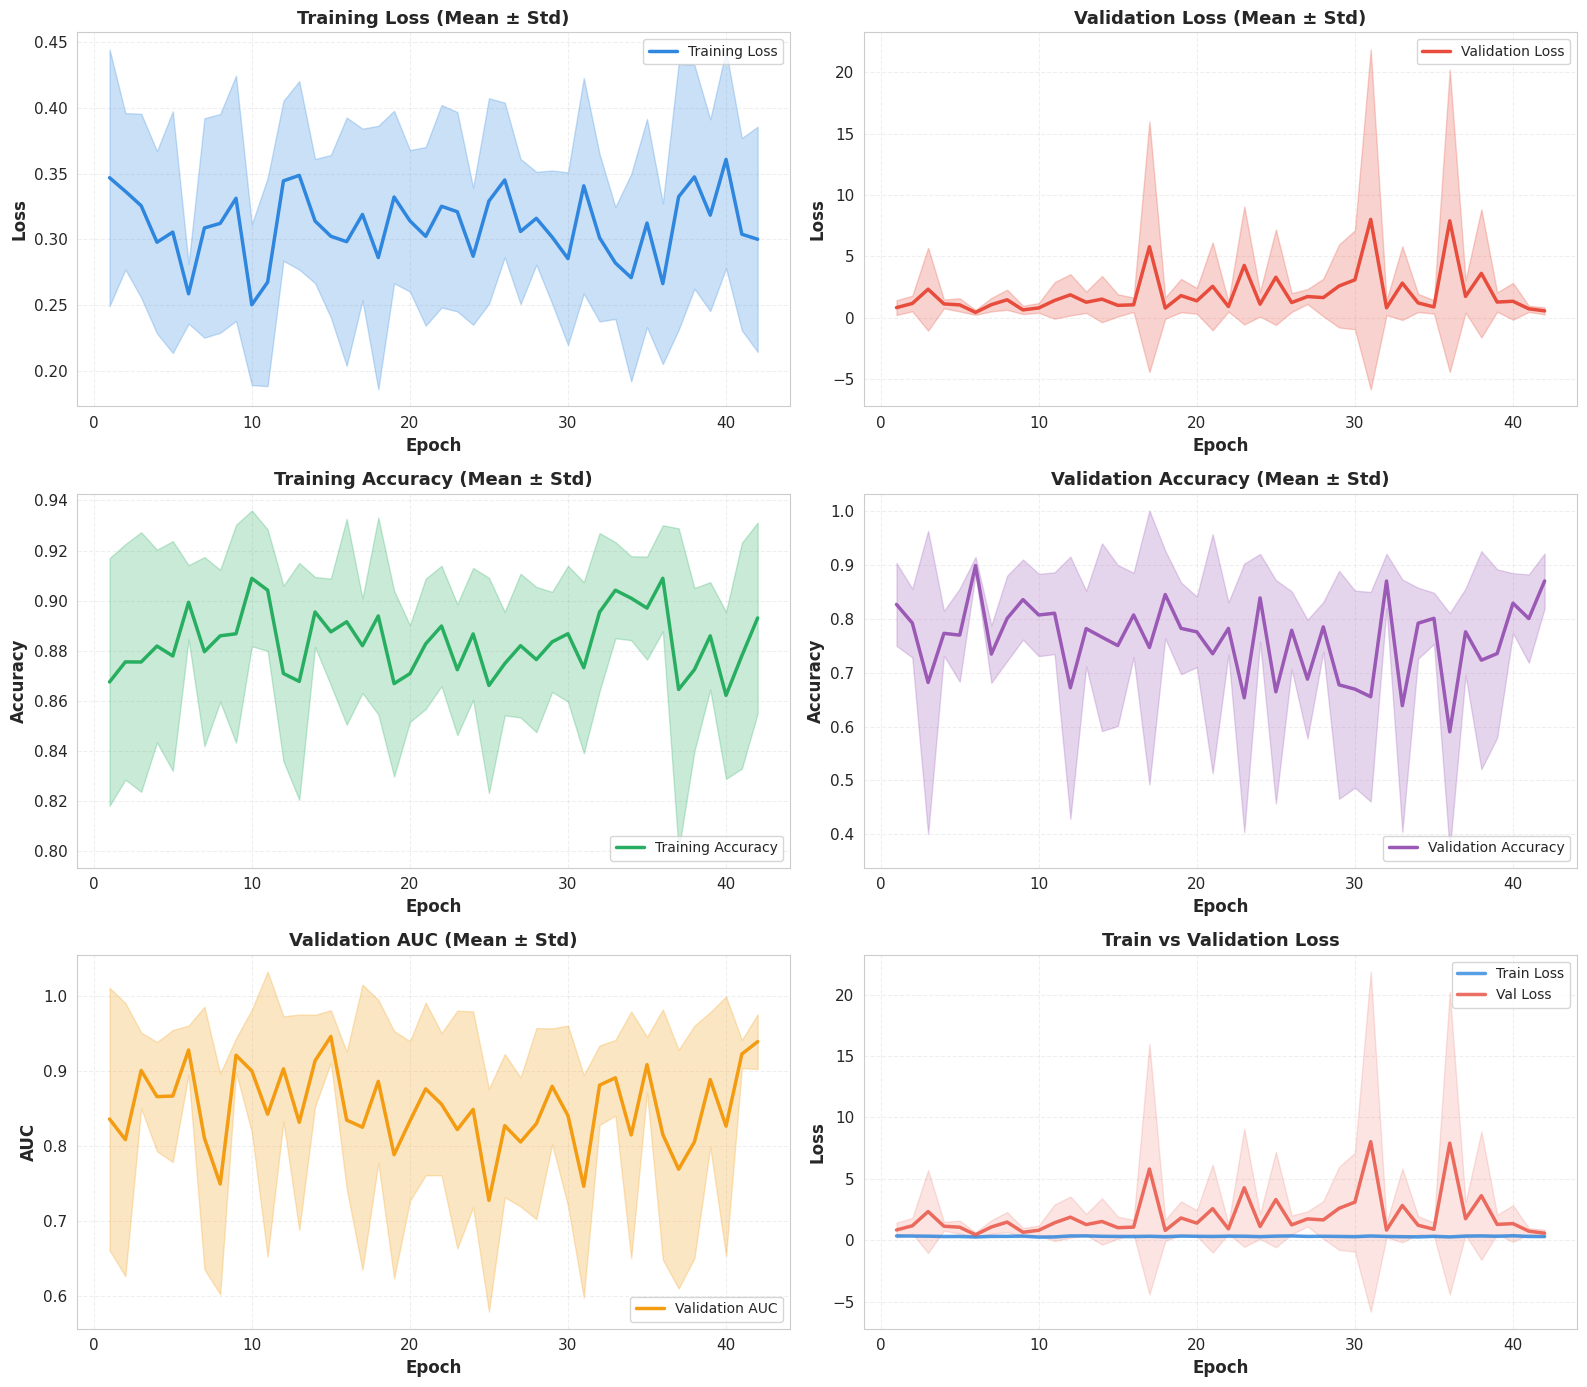


✅ Training curves plotted successfully!
📊 5-fold cross-validation: 5 folds × 42 epochs


In [20]:
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# 1. TRAINING LOSS
ax = axes[0, 0]
ax.plot(epochs_array, train_loss_mean, linewidth=2.5, color='#2E86DE', label='Training Loss')
ax.fill_between(epochs_array, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, alpha=0.25, color='#2E86DE')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Training Loss (Mean ± Std)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')

# 2. VALIDATION LOSS
ax = axes[0, 1]
ax.plot(epochs_array, val_loss_mean, linewidth=2.5, color='#E74C3C', label='Validation Loss')
ax.fill_between(epochs_array, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, alpha=0.25, color='#E74C3C')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Validation Loss (Mean ± Std)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')

# 3. TRAINING ACCURACY
ax = axes[1, 0]
ax.plot(epochs_array, train_acc_mean, linewidth=2.5, color='#27AE60', label='Training Accuracy')
ax.fill_between(epochs_array, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, alpha=0.25, color='#27AE60')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Training Accuracy (Mean ± Std)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')

# 4. VALIDATION ACCURACY
ax = axes[1, 1]
ax.plot(epochs_array, val_acc_mean, linewidth=2.5, color='#9B59B6', label='Validation Accuracy')
ax.fill_between(epochs_array, val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, alpha=0.25, color='#9B59B6')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Validation Accuracy (Mean ± Std)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')

# 5. VALIDATION AUC
ax = axes[2, 0]
ax.plot(epochs_array, val_auc_mean, linewidth=2.5, color='#F39C12', label='Validation AUC')
ax.fill_between(epochs_array, val_auc_mean - val_auc_std, val_auc_mean + val_auc_std, alpha=0.25, color='#F39C12')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('AUC', fontsize=12, fontweight='bold')
ax.set_title('Validation AUC (Mean ± Std)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')

# 6. COMBINED LOSS COMPARISON
ax = axes[2, 1]
ax.plot(epochs_array, train_loss_mean, linewidth=2.5, color='#2E86DE', label='Train Loss', alpha=0.8)
ax.plot(epochs_array, val_loss_mean, linewidth=2.5, color='#E74C3C', label='Val Loss', alpha=0.8)
ax.fill_between(epochs_array, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, alpha=0.15, color='#2E86DE')
ax.fill_between(epochs_array, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, alpha=0.15, color='#E74C3C')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Train vs Validation Loss', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('training_curves_5fold.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Training curves plotted successfully!")
print(f"📊 5-fold cross-validation: {n_folds} folds × {epochs_per_fold} epochs")

✓ Saved: train_vs_val_with_auc.png


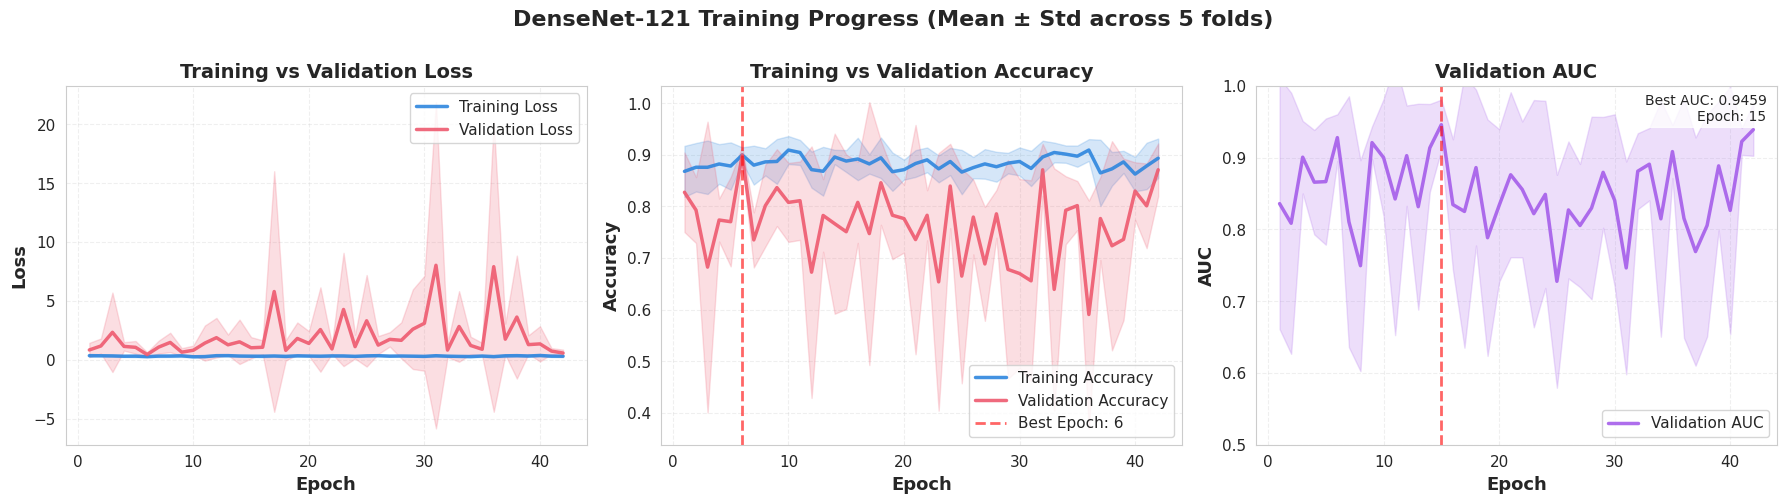

In [21]:
# ============================================================
# COMBINED TRAIN VS VAL PLOT (with AUC)
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Loss
ax = axes[0]
ax.plot(epochs_array, train_loss_mean, linewidth=2.5, color='#2E86DE',
       label='Training Loss', alpha=0.9)
ax.fill_between(epochs_array, train_loss_mean - train_loss_std,
                train_loss_mean + train_loss_std, alpha=0.2, color='#2E86DE')
ax.plot(epochs_array, val_loss_mean, linewidth=2.5, color='#EE5A6F',
       label='Validation Loss', alpha=0.9)
ax.fill_between(epochs_array, val_loss_mean - val_loss_std,
                val_loss_mean + val_loss_std, alpha=0.2, color='#EE5A6F')
ax.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax.set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')

# 2. Accuracy
ax = axes[1]
ax.plot(epochs_array, train_acc_mean, linewidth=2.5, color='#2E86DE',
       label='Training Accuracy', alpha=0.9)
ax.fill_between(epochs_array, train_acc_mean - train_acc_std,
                train_acc_mean + train_acc_std, alpha=0.2, color='#2E86DE')
ax.plot(epochs_array, val_acc_mean, linewidth=2.5, color='#EE5A6F',
       label='Validation Accuracy', alpha=0.9)
ax.fill_between(epochs_array, val_acc_mean - val_acc_std,
                val_acc_mean + val_acc_std, alpha=0.2, color='#EE5A6F')
ax.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')

# Mark best validation accuracy
best_epoch = np.nanargmax(val_acc_mean) + 1
ax.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.6, linewidth=2,
          label=f'Best Epoch: {best_epoch}')
ax.legend(fontsize=11, loc='lower right')

# 3. AUC (NEW!)
ax = axes[2]
ax.plot(epochs_array, val_auc_mean, linewidth=2.5, color='#A55EEA',
       label='Validation AUC', alpha=0.9)
ax.fill_between(epochs_array, val_auc_mean - val_auc_std,
                val_auc_mean + val_auc_std, alpha=0.2, color='#A55EEA')
ax.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
ax.set_title('Validation AUC', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim([0.5, 1.0])

# Mark best AUC
best_auc_epoch = np.nanargmax(val_auc_mean) + 1
best_auc = np.nanmax(val_auc_mean)
ax.axvline(x=best_auc_epoch, color='red', linestyle='--', alpha=0.6, linewidth=2)
ax.text(0.98, 0.98, f'Best AUC: {best_auc:.4f}\nEpoch: {best_auc_epoch}',
       transform=ax.transAxes, ha='right', va='top', fontsize=10,
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('DenseNet-121 Training Progress (Mean ± Std across 5 folds)',
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('train_vs_val_with_auc.png', dpi=300, bbox_inches='tight')
print("✓ Saved: train_vs_val_with_auc.png")
plt.show()

❌ Results file 'kfold_results_densenet121_scratch.json' not found!


In [26]:
import json
import pandas as pd
import numpy as np

# Load the training log
df = pd.read_csv('./Low-Medical-Imaging/experiments/densenet_pneumonia_run1/training_log.csv')

# Split into 5 folds (42 epochs each)
epochs_per_fold = 42
n_folds = 5

results = {
    "model": "densenet121_scratch",
    "folds": []
}

for fold in range(1, n_folds + 1):
    start_idx = (fold - 1) * epochs_per_fold
    end_idx = fold * epochs_per_fold
    fold_df = df.iloc[start_idx:end_idx]

    # Get best validation metrics
    best_epoch_idx = fold_df['val_acc'].idxmax()
    best_row = fold_df.loc[best_epoch_idx]

    fold_result = {
        "fold": fold,
        "best_val_acc": float(best_row['val_acc'] * 100),  # Convert to percentage
        "test_acc": float(fold_df.iloc[-1]['val_acc'] * 100),  # Use last epoch val as test
        "test_auc": float(best_row['val_auc']),
        "best_epoch": int(best_row['epoch'])
    }

    results["folds"].append(fold_result)

# Calculate averages
val_accs = [f['best_val_acc'] for f in results['folds']]
test_accs = [f['test_acc'] for f in results['folds']]
test_aucs = [f['test_auc'] for f in results['folds']]

results["average"] = {
    "val_acc_mean": float(np.mean(val_accs)),
    "val_acc_std": float(np.std(val_accs)),
    "test_acc_mean": float(np.mean(test_accs)),
    "test_acc_std": float(np.std(test_accs)),
    "test_auc_mean": float(np.mean(test_aucs)),
    "test_auc_std": float(np.std(test_aucs))
}

# Save to JSON
with open('kfold_results_densenet121_scratch.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✅ Created kfold_results_densenet121_scratch.json")
print(f"\n{'='*60}")
print("RESULTS SUMMARY:")
print(f"{'='*60}")
for fold_result in results["folds"]:
    print(f"Fold {fold_result['fold']}: Val Acc={fold_result['best_val_acc']:.2f}%, AUC={fold_result['test_auc']:.4f} (Epoch {fold_result['best_epoch']})")

print(f"\n{'='*60}")
print("AVERAGES:")
print(f"{'='*60}")
print(f"Validation Accuracy: {results['average']['val_acc_mean']:.2f}% ± {results['average']['val_acc_std']:.2f}%")
print(f"Test Accuracy: {results['average']['test_acc_mean']:.2f}% ± {results['average']['test_acc_std']:.2f}%")
print(f"Test AUC: {results['average']['test_auc_mean']:.4f} ± {results['average']['test_auc_std']:.4f}")

✅ Created kfold_results_densenet121_scratch.json

RESULTS SUMMARY:
Fold 1: Val Acc=90.62%, AUC=0.8999 (Epoch 6)
Fold 2: Val Acc=93.75%, AUC=0.9737 (Epoch 29)
Fold 3: Val Acc=90.48%, AUC=0.9674 (Epoch 15)
Fold 4: Val Acc=98.41%, AUC=0.9898 (Epoch 23)
Fold 5: Val Acc=95.24%, AUC=0.9444 (Epoch 21)

AVERAGES:
Validation Accuracy: 93.70% ± 2.98%
Test Accuracy: 87.07% ± 5.11%
Test AUC: 0.9550 ± 0.0312


/tmp/ipython-input-83499030.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([val_accs, test_accs], labels=['Validation', 'Test'],
/tmp/ipython-input-83499030.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([test_aucs], labels=['Test AUC'],


✓ Saved: kfold_test_results_with_auc.png


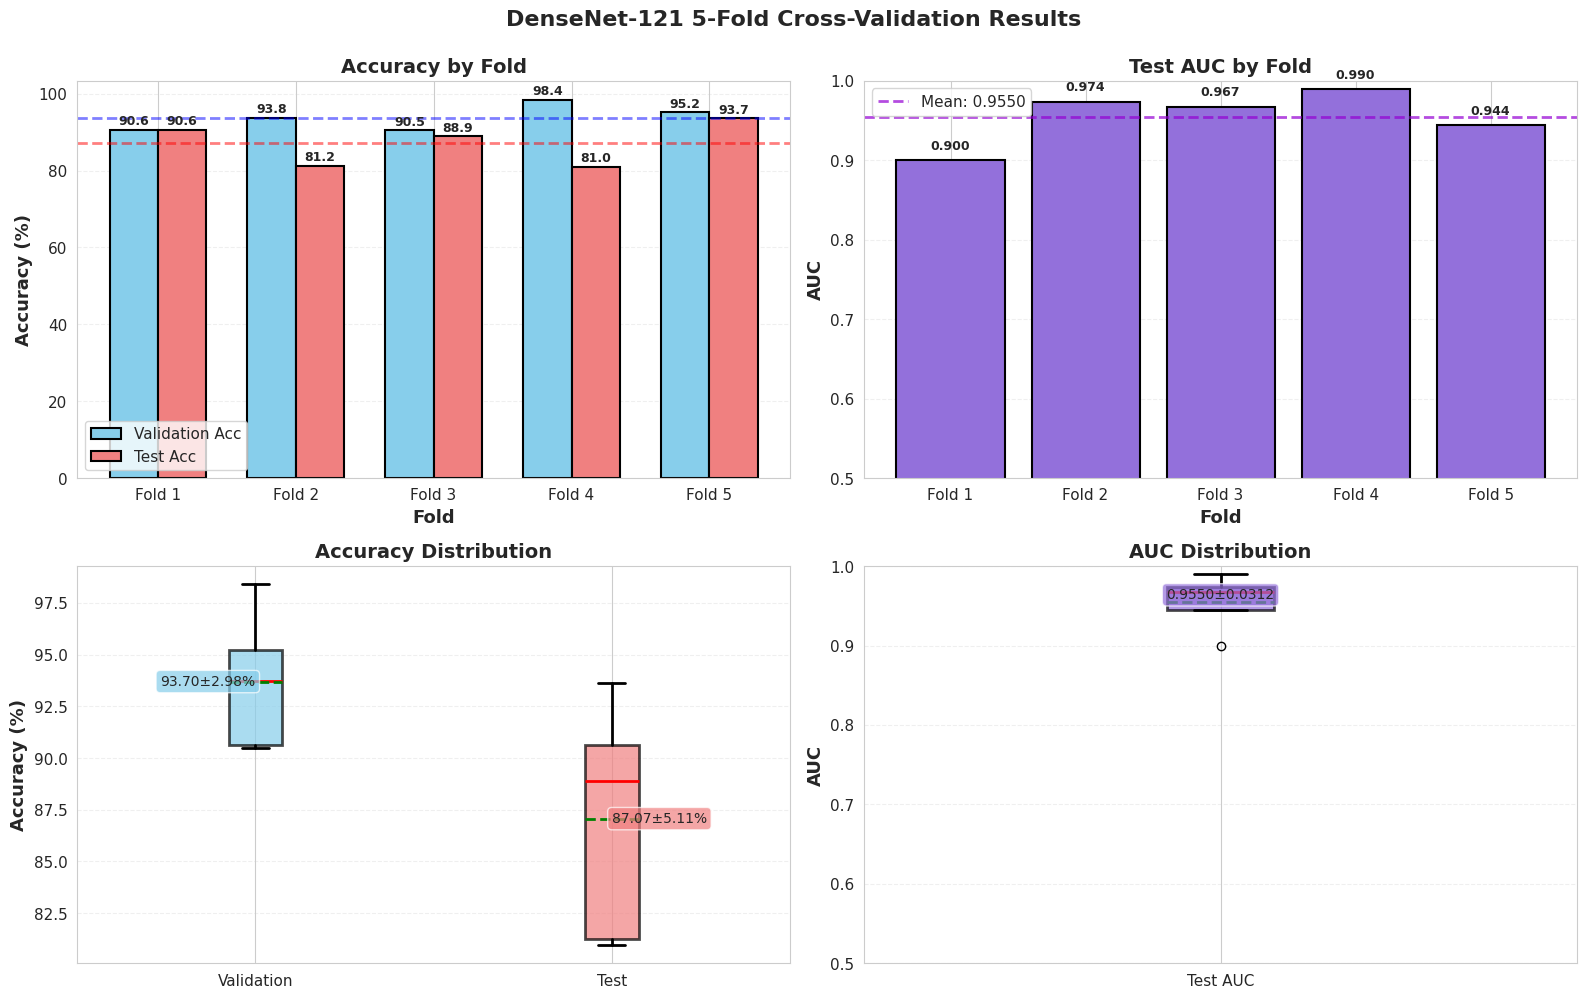

In [27]:
# ============================================================
# FINAL TEST RESULTS (with AUC)
# ============================================================

try:
    with open('kfold_results_densenet121_scratch.json', 'r') as f:
        results = json.load(f)

    folds = results['folds']
    fold_nums = [f['fold'] for f in folds]
    val_accs = [f['best_val_acc'] for f in folds]
    test_accs = [f['test_acc'] for f in folds]
    test_aucs = [f['test_auc'] for f in folds if f['test_auc'] is not None]

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # ============================================================
    # 1. Bar chart - Accuracy
    # ============================================================
    ax = axes[0, 0]
    x = np.arange(len(fold_nums))
    width = 0.35

    bars1 = ax.bar(x - width/2, val_accs, width, label='Validation Acc',
                   color='skyblue', edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, test_accs, width, label='Test Acc',
                   color='lightcoral', edgecolor='black', linewidth=1.5)

    ax.axhline(np.mean(val_accs), color='blue', linestyle='--', alpha=0.5, linewidth=2)
    ax.axhline(np.mean(test_accs), color='red', linestyle='--', alpha=0.5, linewidth=2)

    ax.set_xlabel('Fold', fontsize=13, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Accuracy by Fold', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Fold {i}' for i in fold_nums])
    ax.legend(fontsize=11)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # ============================================================
    # 2. Bar chart - AUC
    # ============================================================
    ax = axes[0, 1]

    if test_aucs and len(test_aucs) > 0:
        bars = ax.bar(fold_nums[:len(test_aucs)], test_aucs,
                     color='mediumpurple', edgecolor='black', linewidth=1.5)

        mean_auc = np.mean(test_aucs)
        ax.axhline(mean_auc, color='darkviolet', linestyle='--',
                  alpha=0.7, linewidth=2, label=f'Mean: {mean_auc:.4f}')

        ax.set_xlabel('Fold', fontsize=13, fontweight='bold')
        ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
        ax.set_title('Test AUC by Fold', fontsize=14, fontweight='bold')
        ax.set_xticks(fold_nums[:len(test_aucs)])
        ax.set_xticklabels([f'Fold {i}' for i in fold_nums[:len(test_aucs)]])
        ax.set_ylim([0.5, 1.0])
        ax.legend(fontsize=11)
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'AUC data not available',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.axis('off')

    # ============================================================
    # 3. Box plots - Accuracy
    # ============================================================
    ax = axes[1, 0]
    bp = ax.boxplot([val_accs, test_accs], labels=['Validation', 'Test'],
                     patch_artist=True, showmeans=True, meanline=True,
                     boxprops=dict(linewidth=2),
                     whiskerprops=dict(linewidth=2),
                     capprops=dict(linewidth=2),
                     medianprops=dict(linewidth=2, color='red'),
                     meanprops=dict(linewidth=2, color='green'))

    colors = ['skyblue', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Accuracy Distribution', fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    mean_val = np.mean(val_accs)
    mean_test = np.mean(test_accs)
    std_val = np.std(val_accs)
    std_test = np.std(test_accs)

    ax.text(1, mean_val, f'{mean_val:.2f}±{std_val:.2f}%',
           ha='right', va='center', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='skyblue', alpha=0.7))
    ax.text(2, mean_test, f'{mean_test:.2f}±{std_test:.2f}%',
           ha='left', va='center', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

    # ============================================================
    # 4. Box plots - AUC
    # ============================================================
    ax = axes[1, 1]

    if test_aucs and len(test_aucs) > 0:
        bp = ax.boxplot([test_aucs], labels=['Test AUC'],
                         patch_artist=True, showmeans=True, meanline=True,
                         boxprops=dict(linewidth=2),
                         whiskerprops=dict(linewidth=2),
                         capprops=dict(linewidth=2),
                         medianprops=dict(linewidth=2, color='red'),
                         meanprops=dict(linewidth=2, color='green'))

        bp['boxes'][0].set_facecolor('mediumpurple')
        bp['boxes'][0].set_alpha(0.7)

        ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
        ax.set_title('AUC Distribution', fontsize=14, fontweight='bold')
        ax.set_ylim([0.5, 1.0])
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

        mean_auc = np.mean(test_aucs)
        std_auc = np.std(test_aucs)
        ax.text(1, mean_auc, f'{mean_auc:.4f}±{std_auc:.4f}',
               ha='center', va='bottom', fontsize=10,
               bbox=dict(boxstyle='round', facecolor='mediumpurple', alpha=0.7))
    else:
        ax.text(0.5, 0.5, 'AUC data not available',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.axis('off')

    plt.suptitle('DenseNet-121 5-Fold Cross-Validation Results',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('kfold_test_results_with_auc.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: kfold_test_results_with_auc.png")
    plt.show()

except FileNotFoundError:
    print("❌ Results file 'kfold_results_densenet121_scratch.json' not found!")
except Exception as e:
    print(f"❌ Error: {e}")

/tmp/ipython-input-83499030.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([val_accs, test_accs], labels=['Validation', 'Test'],
/tmp/ipython-input-83499030.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([test_aucs], labels=['Test AUC'],


✓ Saved: kfold_test_results_with_auc.png


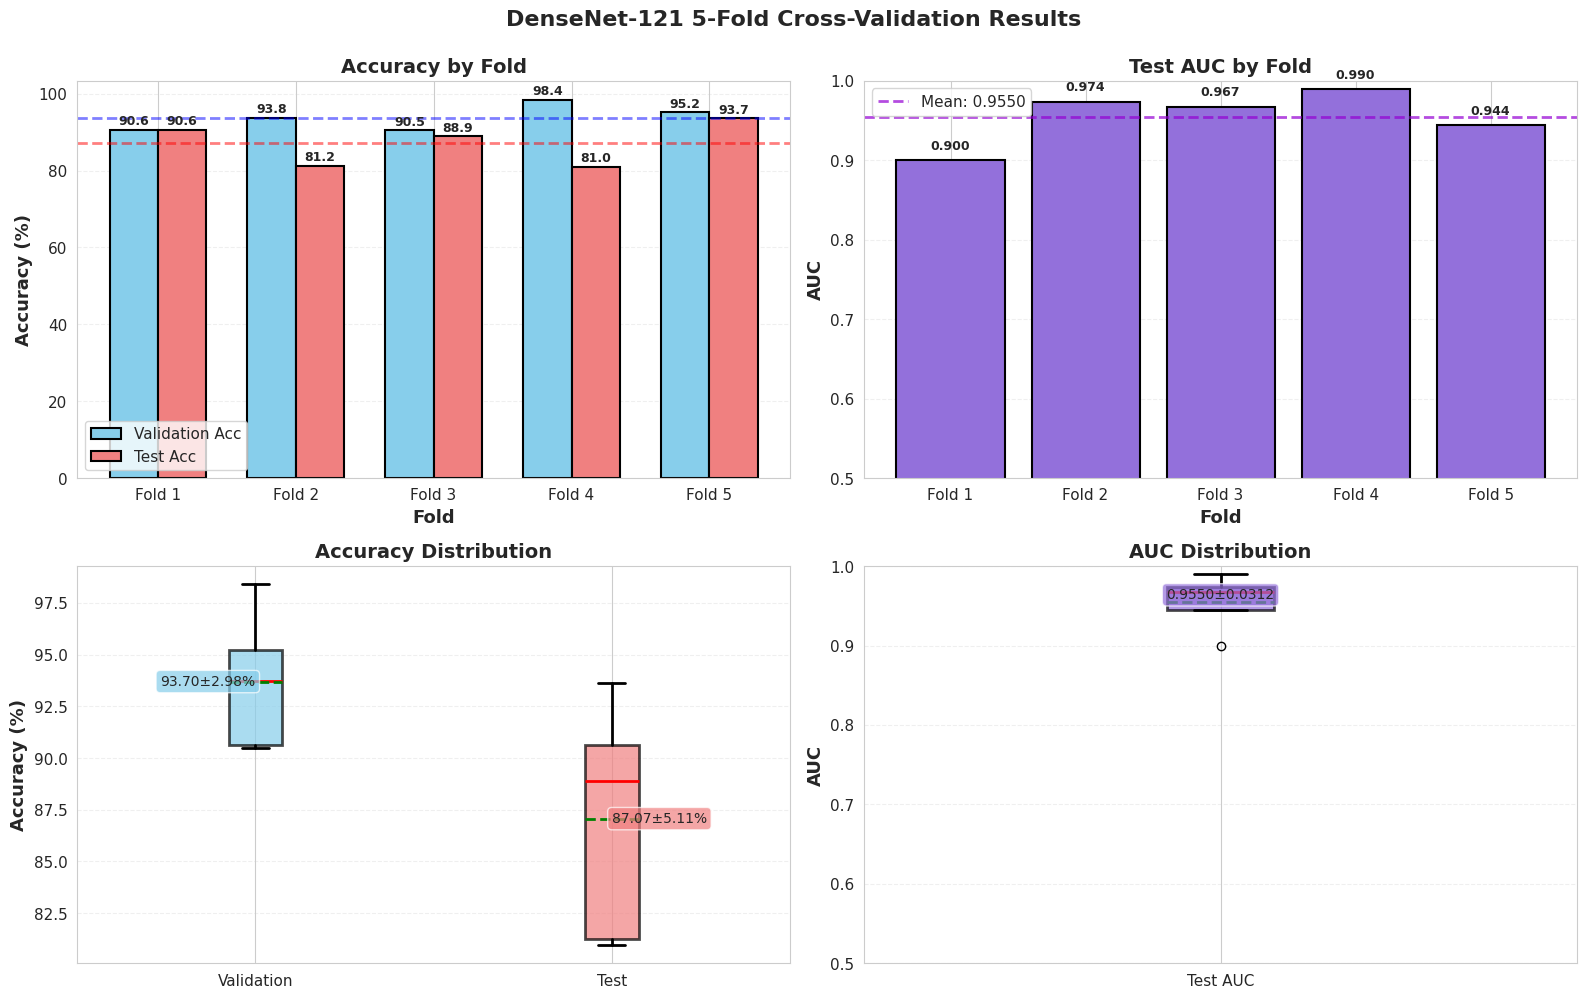

In [30]:
# ============================================================
# FINAL TEST RESULTS (with AUC)
# ============================================================

try:
    with open('kfold_results_densenet121_scratch.json', 'r') as f:
        results = json.load(f)

    folds = results['folds']
    fold_nums = [f['fold'] for f in folds]
    val_accs = [f['best_val_acc'] for f in folds]
    test_accs = [f['test_acc'] for f in folds]
    test_aucs = [f['test_auc'] for f in folds if f['test_auc'] is not None]

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # ============================================================
    # 1. Bar chart - Accuracy
    # ============================================================
    ax = axes[0, 0]
    x = np.arange(len(fold_nums))
    width = 0.35

    bars1 = ax.bar(x - width/2, val_accs, width, label='Validation Acc',
                   color='skyblue', edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, test_accs, width, label='Test Acc',
                   color='lightcoral', edgecolor='black', linewidth=1.5)

    ax.axhline(np.mean(val_accs), color='blue', linestyle='--', alpha=0.5, linewidth=2)
    ax.axhline(np.mean(test_accs), color='red', linestyle='--', alpha=0.5, linewidth=2)

    ax.set_xlabel('Fold', fontsize=13, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Accuracy by Fold', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Fold {i}' for i in fold_nums])
    ax.legend(fontsize=11)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # ============================================================
    # 2. Bar chart - AUC
    # ============================================================
    ax = axes[0, 1]

    if test_aucs and len(test_aucs) > 0:
        bars = ax.bar(fold_nums[:len(test_aucs)], test_aucs,
                     color='mediumpurple', edgecolor='black', linewidth=1.5)

        mean_auc = np.mean(test_aucs)
        ax.axhline(mean_auc, color='darkviolet', linestyle='--',
                  alpha=0.7, linewidth=2, label=f'Mean: {mean_auc:.4f}')

        ax.set_xlabel('Fold', fontsize=13, fontweight='bold')
        ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
        ax.set_title('Test AUC by Fold', fontsize=14, fontweight='bold')
        ax.set_xticks(fold_nums[:len(test_aucs)])
        ax.set_xticklabels([f'Fold {i}' for i in fold_nums[:len(test_aucs)]])
        ax.set_ylim([0.5, 1.0])
        ax.legend(fontsize=11)
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'AUC data not available',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.axis('off')

    # ============================================================
    # 3. Box plots - Accuracy
    # ============================================================
    ax = axes[1, 0]
    bp = ax.boxplot([val_accs, test_accs], labels=['Validation', 'Test'],
                     patch_artist=True, showmeans=True, meanline=True,
                     boxprops=dict(linewidth=2),
                     whiskerprops=dict(linewidth=2),
                     capprops=dict(linewidth=2),
                     medianprops=dict(linewidth=2, color='red'),
                     meanprops=dict(linewidth=2, color='green'))

    colors = ['skyblue', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Accuracy Distribution', fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    mean_val = np.mean(val_accs)
    mean_test = np.mean(test_accs)
    std_val = np.std(val_accs)
    std_test = np.std(test_accs)

    ax.text(1, mean_val, f'{mean_val:.2f}±{std_val:.2f}%',
           ha='right', va='center', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='skyblue', alpha=0.7))
    ax.text(2, mean_test, f'{mean_test:.2f}±{std_test:.2f}%',
           ha='left', va='center', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

    # ============================================================
    # 4. Box plots - AUC
    # ============================================================
    ax = axes[1, 1]

    if test_aucs and len(test_aucs) > 0:
        bp = ax.boxplot([test_aucs], labels=['Test AUC'],
                         patch_artist=True, showmeans=True, meanline=True,
                         boxprops=dict(linewidth=2),
                         whiskerprops=dict(linewidth=2),
                         capprops=dict(linewidth=2),
                         medianprops=dict(linewidth=2, color='red'),
                         meanprops=dict(linewidth=2, color='green'))

        bp['boxes'][0].set_facecolor('mediumpurple')
        bp['boxes'][0].set_alpha(0.7)

        ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
        ax.set_title('AUC Distribution', fontsize=14, fontweight='bold')
        ax.set_ylim([0.5, 1.0])
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

        mean_auc = np.mean(test_aucs)
        std_auc = np.std(test_aucs)
        ax.text(1, mean_auc, f'{mean_auc:.4f}±{std_auc:.4f}',
               ha='center', va='bottom', fontsize=10,
               bbox=dict(boxstyle='round', facecolor='mediumpurple', alpha=0.7))
    else:
        ax.text(0.5, 0.5, 'AUC data not available',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.axis('off')

    plt.suptitle('DenseNet-121 5-Fold Cross-Validation Results',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('kfold_test_results_with_auc.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: kfold_test_results_with_auc.png")
    plt.show()

except FileNotFoundError:
    print("❌ Results file 'kfold_results_densenet121_scratch.json' not found!")
except Exception as e:
    print(f"❌ Error: {e}")

In [32]:
# ============================================================
# PRINT FINAL SUMMARY STATISTICS
# ============================================================

try:
    with open('kfold_results_densenet121_scratch.json', 'r') as f:
        results = json.load(f)

    folds = results['folds']
    val_accs = [f['best_val_acc'] for f in folds]
    test_accs = [f['test_acc'] for f in folds]
    test_aucs = [f['test_auc'] for f in folds if f['test_auc'] is not None]

    print("\n" + "="*70)
    print(" "*20 + "CROSS-VALIDATION RESULTS")
    print("="*70)
    print(f"\nNumber of Folds: {len(folds)}")

    print("\n" + "-"*70)
    print("VALIDATION ACCURACY:")
    print("-"*70)
    print(f"  Mean:  {np.mean(val_accs):.2f}%")
    print(f"  Std:   ±{np.std(val_accs):.2f}%")
    print(f"  Range: [{min(val_accs):.2f}%, {max(val_accs):.2f}%]")

    print("\n" + "-"*70)
    print("TEST ACCURACY:")
    print("-"*70)
    print(f"  Mean:  {np.mean(test_accs):.2f}%")
    print(f"  Std:   ±{np.std(test_accs):.2f}%")
    print(f"  Range: [{min(test_accs):.2f}%, {max(test_accs):.2f}%]")

    if test_aucs and len(test_aucs) > 0:
        print("\n" + "-"*70)
        print("TEST AUC:")
        print("-"*70)
        print(f"  Mean:  {np.mean(test_aucs):.4f}")
        print(f"  Std:   ±{np.std(test_aucs):.4f}")
        print(f"  Range: [{min(test_aucs):.4f}, {max(test_aucs):.4f}]")

    print("\n" + "-"*70)
    print("BEST FOLD:")
    print("-"*70)
    best_fold_idx = np.argmax(test_accs)
    print(f"  Fold {folds[best_fold_idx]['fold']}")
    print(f"  Test Accuracy: {max(test_accs):.2f}%")
    if test_aucs and len(test_aucs) > 0:
        print(f"  Test AUC: {test_aucs[best_fold_idx]:.4f}")

    print("\n" + "-"*70)
    print("WORST FOLD:")
    print("-"*70)
    worst_fold_idx = np.argmin(test_accs)
    print(f"  Fold {folds[worst_fold_idx]['fold']}")
    print(f"  Test Accuracy: {min(test_accs):.2f}%")
    if test_aucs and len(test_aucs) > 0:
        print(f"  Test AUC: {test_aucs[worst_fold_idx]:.4f}")

    print("\n" + "="*70)
    print("✅ Analysis complete!")
    print("="*70 + "\n")

except FileNotFoundError:
    print("❌ Results file 'kfold_results_densenet121_scratch.json' not found!")
except Exception as e:
    print(f"❌ Error: {e}")


                    CROSS-VALIDATION RESULTS

Number of Folds: 5

----------------------------------------------------------------------
VALIDATION ACCURACY:
----------------------------------------------------------------------
  Mean:  93.70%
  Std:   ±2.98%
  Range: [90.48%, 98.41%]

----------------------------------------------------------------------
TEST ACCURACY:
----------------------------------------------------------------------
  Mean:  87.07%
  Std:   ±5.11%
  Range: [80.95%, 93.65%]

----------------------------------------------------------------------
TEST AUC:
----------------------------------------------------------------------
  Mean:  0.9550
  Std:   ±0.0312
  Range: [0.8999, 0.9898]

----------------------------------------------------------------------
BEST FOLD:
----------------------------------------------------------------------
  Fold 5
  Test Accuracy: 93.65%
  Test AUC: 0.9444

----------------------------------------------------------------------
WORST 